# Adapting the 2nd Place Solution of the 2021 NCAAW Competition

- Solution write-up is available here : https://www.kaggle.com/c/ncaaw-march-mania-2021/discussion/230705
- 2nd place code : https://www.kaggle.com/theoviel/2nd-place-ncaaw-2021?scriptVersionId=58780991
- It was adapted from this notebook : https://www.kaggle.com/theoviel/ncaa-starter-the-simpler-the-better 


In [1]:
import os
import re
import sklearn
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *

pd.set_option('display.max_columns', None)

In [2]:
DATA_PATH = '/kaggle/input/march-machine-learning-mania-2023/'

for filename in os.listdir(DATA_PATH):
    print(filename)

Conferences.csv
WNCAATourneyDetailedResults.csv
WRegularSeasonCompactResults.csv
MNCAATourneySeedRoundSlots.csv
MRegularSeasonDetailedResults.csv
MNCAATourneyCompactResults.csv
MGameCities.csv
WGameCities.csv
MSeasons.csv
WNCAATourneySlots.csv
MSecondaryTourneyTeams.csv
Cities.csv
SampleSubmission2023.csv
MTeamSpellings.csv
MRegularSeasonCompactResults.csv
MSecondaryTourneyCompactResults.csv
MMasseyOrdinals_thru_Season2023_Day128.csv
WTeams.csv
MNCAATourneySlots.csv
MNCAATourneySeeds.csv
WNCAATourneyCompactResults.csv
WSeasons.csv
WNCAATourneySeeds.csv
MTeamCoaches.csv
MConferenceTourneyGames.csv
WRegularSeasonDetailedResults.csv
MNCAATourneyDetailedResults.csv
WTeamSpellings.csv
MTeamConferences.csv
MTeams.csv
WTeamConferences.csv


# Data preparation

## Seeds
> This file identifies the seeds for all teams in each NCAA® tournament, for all seasons of historical data. Thus, there are between 64-68 rows for each year, depending on whether there were any play-in games and how many there were. In recent years the structure has settled at 68 total teams, with four "play-in" games leading to the final field of 64 teams entering Round 1 on Thursday of the first week (by definition, that is DayNum=136 each season). We will not know the seeds of the respective tournament teams, or even exactly which 68 teams it will be, until Selection Sunday on March 15, 2020 (DayNum=132).

> The seed is a 3/4-character :
- First character : Region (W, X, Y, or Z)
- Next two digits : Seed within the region (01 to 16)
- Last character (optional): Distinguishes teams between play-ins ( a or b)

In [3]:
df_seeds = pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv")
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


## Season results
> This file identifies the game-by-game results for many seasons of historical data, starting with the 1985 season (the first year the NCAA® had a 64-team tournament). For each season, the file includes all games played from DayNum 0 through 132. It is important to realize that the "Regular Season" games are simply defined to be all games played on DayNum=132 or earlier (DayNum=132 is Selection Sunday, and there are always a few conference tournament finals actually played early in the day on Selection Sunday itself). Thus a game played on or before Selection Sunday will show up here whether it was a pre-season tournament, a non-conference game, a regular conference game, a conference tournament game, or whatever.

In [4]:
df_season_results = pd.read_csv(DATA_PATH + "MRegularSeasonDetailedResults.csv")
df_season_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [5]:
df_season_results['ScoreGap'] = df_season_results['WScore'] - df_season_results['LScore']
df_season_results['AstGap'] = df_season_results['WAst'] - df_season_results['LAst']
df_season_results['FTAGap'] = df_season_results['WFTA'] - df_season_results['LFTA']
df_season_results['DRGap'] = df_season_results['WDR'] - df_season_results['LDR']
df_season_results['TOGap'] = df_season_results['WTO'] - df_season_results['LTO']

In [6]:
df_season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,ScoreGap,AstGap,FTAGap,DRGap,TOGap
0,2003,10,1104,68,1328,62,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,6,5,-4,2,5
1,2003,10,1272,70,1393,63,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,7,9,-1,3,1
2,2003,11,1266,73,1437,61,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,12,6,6,4,-2
3,2003,11,1296,56,1457,50,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,6,2,16,-1,-7
4,2003,11,1400,77,1208,71,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14,6,0,-14,7,4


### Features 
For each team at each season, I compute : 
- Number of wins
- Number of losses
- Average score gap of wins
- Average score gap of losses

And use the following features : 
- Win Ratio
- Average score gap

For games in the recent 30 days and games before
:
- Effective Field Goal Percentage
- Turnover Rate
- Offensive Rebounding Percentage
- Free Throw Rate

In [7]:
df_rec = df_season_results.loc[(df_season_results.DayNum >= 90)]
df_past = df_season_results.loc[(df_season_results.DayNum < 90)]

In [8]:
rec_win = df_rec.groupby(['Season', 'WTeamID']).count()
rec_win = rec_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "RecWins", "WTeamID": "TeamID"})
past_win = df_past.groupby(['Season', 'WTeamID']).count()
past_win = past_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "PastWins", "WTeamID": "TeamID"})

In [9]:
num_win = df_season_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})

In [10]:
rec_loss = df_rec.groupby(['Season', 'LTeamID']).count()
rec_loss = rec_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "RecLosses", "LTeamID": "TeamID"})
past_loss = df_past.groupby(['Season', 'LTeamID']).count()
past_loss = past_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "PastLosses", "LTeamID": "TeamID"})

In [11]:
num_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})

In [12]:
gap_win = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
gap_win = gap_win[['Season', 'WTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapWins", "WTeamID": "TeamID"})

In [13]:
gap_loss = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
gap_loss = gap_loss[['Season', 'LTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapLosses", "LTeamID": "TeamID"})

In [14]:
df_rec

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,ScoreGap,AstGap,FTAGap,DRGap,TOGap
2923,2003,90,1110,79,1119,64,26,53,13,24,14,17,12,17,17,14,6,1,15,25,47,11,21,3,5,6,17,16,19,7,1,20,15,1,12,0,-5
2924,2003,90,1127,61,1436,50,21,52,8,24,11,14,8,32,9,15,5,9,13,18,67,4,25,10,13,17,25,9,11,4,2,16,11,0,1,7,4
2925,2003,90,1159,77,1250,68,26,58,8,22,17,22,12,25,11,9,6,0,22,24,57,5,14,15,21,14,22,6,12,6,1,18,9,5,1,3,-3
2926,2003,90,1199,75,1181,70,30,50,3,7,12,21,8,30,13,17,6,4,19,25,72,12,37,8,14,18,17,17,12,11,1,21,5,-4,7,13,5
2927,2003,90,1219,75,1347,64,23,49,9,18,20,31,12,28,19,9,5,3,22,22,59,8,23,12,20,13,22,11,11,5,0,26,11,8,11,6,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107629,2023,132,1104,82,1401,63,27,66,12,36,16,22,21,29,16,12,6,7,19,19,64,5,15,20,24,17,20,6,13,5,2,21,19,10,-2,9,-1
107630,2023,132,1272,75,1222,65,27,53,6,12,15,21,9,27,11,11,4,2,18,20,64,6,25,19,28,22,20,11,10,5,4,19,10,0,-7,7,1
107631,2023,132,1343,74,1463,65,23,57,9,23,19,24,11,25,11,5,3,2,18,22,50,8,22,13,19,6,25,12,10,3,7,20,9,-1,5,0,-5
107632,2023,132,1345,67,1336,65,24,62,6,28,13,20,13,25,17,7,5,0,14,22,51,7,23,14,15,4,27,14,10,4,2,20,2,3,5,-2,-3


In [15]:
win = df_rec.groupby(['Season', 'WTeamID']).sum().reset_index()
ast_recw = win[['Season', 'WTeamID', 'WAst']].rename(columns={"WTeamID": "TeamID", "WAst": "WAst_rec"})
fta_recw = win[['Season', 'WTeamID', 'WFTA']].rename(columns={"WTeamID": "TeamID", "WFTA": "WFTA_rec"})
ftm_recw = win[['Season', 'WTeamID', 'WFTM']].rename(columns={"WTeamID": "TeamID", "WFTM": "WFTM_rec"})

fga_recw = win[['Season', 'WTeamID', 'WFGA']].rename(columns={"WTeamID": "TeamID", "WFGA": "WFGA_rec"})
fgm_recw = win[['Season', 'WTeamID', 'WFGM']].rename(columns={"WTeamID": "TeamID", "WFGM": "WFGM_rec"})
fgm3_recw = win[['Season', 'WTeamID', 'WFGM3']].rename(columns={"WTeamID": "TeamID", "WFGM3": "WFGM3_rec"})

dr_recw = win[['Season', 'WTeamID', 'WDR']].rename(columns={"WTeamID": "TeamID","WDR": "WDR_rec"})
or_recw = win[['Season', 'WTeamID', 'WOR']].rename(columns={"WTeamID": "TeamID","WOR": "WOR_rec"})
to_recw = win[['Season', 'WTeamID', 'WTO']].rename(columns={"WTeamID": "TeamID", "WTO": "WTO_rec"})


In [16]:
win = df_past.groupby(['Season', 'WTeamID']).sum().reset_index()
ast_pastw = win[['Season', 'WTeamID', 'WAst']].rename(columns={"WTeamID": "TeamID", "WAst": "WAst_past"})
fta_pastw = win[['Season', 'WTeamID', 'WFTA']].rename(columns={"WTeamID": "TeamID", "WFTA": "WFTA_past"})
ftm_pastw = win[['Season', 'WTeamID', 'WFTM']].rename(columns={"WTeamID": "TeamID", "WFTM": "WFTM_past"})

fga_pastw = win[['Season', 'WTeamID', 'WFGA']].rename(columns={"WTeamID": "TeamID", "WFGA": "WFGA_past"})
fgm_pastw = win[['Season', 'WTeamID', 'WFGM']].rename(columns={"WTeamID": "TeamID", "WFGM": "WFGM_past"})
fgm3_pastw = win[['Season', 'WTeamID', 'WFGM3']].rename(columns={"WTeamID": "TeamID", "WFGM3": "WFGM3_past"})

dr_pastw = win[['Season', 'WTeamID', 'WDR']].rename(columns={"WTeamID": "TeamID","WDR": "WDR_past"})
or_pastw = win[['Season', 'WTeamID', 'WOR']].rename(columns={"WTeamID": "TeamID","WOR": "WOR_past"})
to_pastw = win[['Season', 'WTeamID', 'WTO']].rename(columns={"WTeamID": "TeamID", "WTO": "WTO_past"})


In [17]:
loss = df_rec.groupby(['Season', 'LTeamID']).sum().reset_index()
ast_recl = loss[['Season', 'LTeamID', 'LAst']].rename(columns={"LTeamID": "TeamID", "LAst": "LAst_rec"})
fta_recl = loss[['Season', 'LTeamID', 'LFTA']].rename(columns={"LTeamID": "TeamID", "LFTA": "LFTA_rec"})
ftm_recl = loss[['Season', 'LTeamID', 'LFTM']].rename(columns={"LTeamID": "TeamID", "LFTM": "LFTM_rec"})

fga_recl = loss[['Season', 'LTeamID', 'LFGA']].rename(columns={"LTeamID": "TeamID", "LFGA": "LFGA_rec"})
fgm_recl = loss[['Season', 'LTeamID', 'LFGM']].rename(columns={"LTeamID": "TeamID", "LFGM": "LFGM_rec"})
fgm3_recl = loss[['Season', 'LTeamID', 'LFGM3']].rename(columns={"LTeamID": "TeamID", "LFGM3": "LFGM3_rec"})

dr_recl = loss[['Season', 'LTeamID', 'LDR']].rename(columns={"LTeamID": "TeamID","LDR": "LDR_rec"})
or_recl = loss[['Season', 'LTeamID', 'LOR']].rename(columns={"LTeamID": "TeamID","LOR": "LOR_rec"})
to_recl = loss[['Season', 'LTeamID', 'LTO']].rename(columns={"LTeamID": "TeamID", "LTO": "LTO_rec"})


In [18]:
loss = df_past.groupby(['Season', 'LTeamID']).sum().reset_index()
ast_pastl = loss[['Season', 'LTeamID', 'LAst']].rename(columns={"LTeamID": "TeamID", "LAst": "LAst_past"})
fta_pastl = loss[['Season', 'LTeamID', 'LFTA']].rename(columns={"LTeamID": "TeamID", "LFTA": "LFTA_past"})
ftm_pastl = loss[['Season', 'LTeamID', 'LFTM']].rename(columns={"LTeamID": "TeamID", "LFTM": "LFTM_past"})

fga_pastl = loss[['Season', 'LTeamID', 'LFGA']].rename(columns={"LTeamID": "TeamID", "LFGA": "LFGA_past"})
fgm_pastl = loss[['Season', 'LTeamID', 'LFGM']].rename(columns={"LTeamID": "TeamID", "LFGM": "LFGM_past"})
fgm3_pastl = loss[['Season', 'LTeamID', 'LFGM3']].rename(columns={"LTeamID": "TeamID", "LFGM3": "LFGM3_past"})

dr_pastl = loss[['Season', 'LTeamID', 'LDR']].rename(columns={"LTeamID": "TeamID","LDR": "LDR_past"})
or_pastl = loss[['Season', 'LTeamID', 'LOR']].rename(columns={"LTeamID": "TeamID","LOR": "LOR_past"})
to_pastl = loss[['Season', 'LTeamID', 'LTO']].rename(columns={"LTeamID": "TeamID", "LTO": "LTO_past"})

Merge

In [19]:
df_features_season_w = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

In [20]:
df_features_season = pd.concat([df_features_season_w, df_features_season_l], 0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  """Entry point for launching an IPython kernel.


In [21]:
df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(rec_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(rec_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(past_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(past_loss, on=['Season', 'TeamID'], how='left')

In [22]:
df_features_season = df_features_season.merge(ast_recw, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(ast_recl, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(ast_pastw, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(ast_pastl, on=['Season', 'TeamID'], how='left')

df_features_season = df_features_season.merge(fta_recw, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fta_recl, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fta_pastw, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fta_pastl, on=['Season', 'TeamID'], how='left')

df_features_season = df_features_season.merge(ftm_recw, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(ftm_recl, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(ftm_pastw, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(ftm_pastl, on=['Season', 'TeamID'], how='left')

df_features_season = df_features_season.merge(or_recw, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(or_recl, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(or_pastw, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(or_pastl, on=['Season', 'TeamID'], how='left')

df_features_season = df_features_season.merge(dr_recw, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(dr_recl, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(dr_pastw, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(dr_pastl, on=['Season', 'TeamID'], how='left')

df_features_season = df_features_season.merge(to_recw, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(to_recl, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(to_pastw, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(to_pastl, on=['Season', 'TeamID'], how='left')

df_features_season = df_features_season.merge(fga_recw, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fga_recl, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fga_pastw, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fga_pastl, on=['Season', 'TeamID'], how='left')

df_features_season = df_features_season.merge(fgm_recw, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fgm_recl, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fgm_pastw, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fgm_pastl, on=['Season', 'TeamID'], how='left')

df_features_season = df_features_season.merge(fgm3_recw, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fgm3_recl, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fgm3_pastw, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fgm3_pastl, on=['Season', 'TeamID'], how='left')


In [23]:
df_features_season.fillna(0, inplace=True)  

In [24]:
df_features_season.head()

,Season,TeamID,NumWins,NumLosses,GapWins,GapLosses,RecWins,RecLosses,PastWins,PastLosses,WAst_rec,LAst_rec,WAst_past,LAst_past,WFTA_rec,LFTA_rec,WFTA_past,LFTA_past,WFTM_rec,LFTM_rec,WFTM_past,LFTM_past,WOR_rec,LOR_rec,WOR_past,LOR_past,WDR_rec,LDR_rec,WDR_past,LDR_past,WTO_rec,LTO_rec,WTO_past,LTO_past,WFGA_rec,LFGA_rec,WFGA_past,LFGA_past,WFGM_rec,LFGM_rec,WFGM_past,LFGM_past,WFGM3_rec,LFGM3_rec,WFGM3_past,LFGM3_past
0,2003,1102,12.0,16.0,15.583333,11.250000,2.0,8.0,10.0,8.0,25.0,80.0,178.0,81.0,58.0,126.0,191.0,104.0,43.0,87.0,120.0,62.0,2.0,36.0,44.0,35.0,35.0,117.0,197.0,122.0,26.0,87.0,107.0,100.0,71.0,321.0,409.0,313.0,47.0,136.0,224.0,129.0,11.0,46.0,109.0,53.0
1,2003,1103,13.0,14.0,9.384615,7.500000,5.0,5.0,8.0,9.0,87.0,69.0,143.0,112.0,104.0,101.0,298.0,195.0,78.0,77.0,212.0,147.0,42.0,48.0,80.0,94.0,96.0,102.0,183.0,157.0,69.0,73.0,94.0,105.0,258.0,263.0,462.0,525.0,143.0,120.0,247.0,223.0,32.0,29.0,39.0,47.0
2,2003,1104,17.0,11.0,13.176471,9.454545,4.0,6.0,13.0,5.0,62.0,48.0,176.0,53.0,93.0,113.0,290.0,90.0,63.0,86.0,209.0,58.0,44.0,89.0,186.0,61.0,107.0,114.0,342.0,107.0,50.0,80.0,172.0,70.0,220.0,351.0,772.0,258.0,116.0,132.0,323.0,102.0,33.0,31.0,87.0,27.0
3,2003,1105,7.0,19.0,13.000000,11.473684,3.0,8.0,4.0,11.0,59.0,122.0,52.0,145.0,80.0,184.0,100.0,204.0,58.0,119.0,76.0,148.0,40.0,108.0,62.0,141.0,72.0,189.0,109.0,231.0,45.0,132.0,81.0,227.0,186.0,511.0,247.0,658.0,81.0,204.0,98.0,251.0,34.0,59.0,30.0,74.0
4,2003,1106,13.0,15.0,10.384615,9.266667,4.0,7.0,9.0,8.0,48.0,69.0,121.0,89.0,100.0,96.0,170.0,95.0,69.0,65.0,99.0,65.0,32.0,84.0,134.0,94.0,110.0,156.0,254.0,148.0,70.0,117.0,160.0,130.0,194.0,391.0,506.0,457.0,93.0,151.0,229.0,183.0,22.0,36.0,54.0,59.0


In [25]:
df_features_season['NumTotal'] = df_features_season['NumWins'] + df_features_season['NumLosses']
df_features_season['RecTotal'] = df_features_season['RecWins'] + df_features_season['RecLosses']
df_features_season['PastTotal'] = df_features_season['PastWins'] + df_features_season['PastLosses']

# recent
df_features_season['AstRecAvg'] = (df_features_season['LAst_rec'] + df_features_season['WAst_rec'])/ df_features_season['RecTotal']
df_features_season['FTARecAvg'] = (df_features_season['LFTA_rec'] + df_features_season['WFTA_rec']) / df_features_season['RecTotal']
df_features_season['FTMRecAvg'] = (df_features_season['LFTM_rec'] + df_features_season['WFTM_rec']) / df_features_season['RecTotal']

df_features_season['DRRecAvg'] = (df_features_season['LDR_rec'] + df_features_season['WDR_rec']) / df_features_season['RecTotal']
df_features_season['ORRecAvg'] = (df_features_season['LOR_rec'] + df_features_season['WOR_rec']) / df_features_season['RecTotal']
df_features_season['TORecAvg'] = (df_features_season['LTO_rec'] + df_features_season['WTO_rec']) /df_features_season['RecTotal']
df_features_season['FGARecAvg'] = (df_features_season['LFGA_rec'] + df_features_season['WFGA_rec']) /df_features_season['RecTotal']
df_features_season['FGMRecAvg'] = (df_features_season['LFGM_rec'] + df_features_season['WFGM_rec']) /df_features_season['RecTotal']
df_features_season['FGM3RecAvg'] = (df_features_season['LFGM3_rec'] + df_features_season['WFGM3_rec']) /df_features_season['RecTotal']

# past
df_features_season['AstPastAvg'] = (df_features_season['LAst_past'] + df_features_season['WAst_past'])/ df_features_season['PastTotal']
df_features_season['FTAPastAvg'] = (df_features_season['LFTA_past'] + df_features_season['WFTA_past']) / df_features_season['PastTotal']
df_features_season['FTMPastAvg'] = (df_features_season['LFTM_past'] + df_features_season['WFTM_past']) / df_features_season['PastTotal']

df_features_season['DRPastAvg'] = (df_features_season['LDR_past'] + df_features_season['WDR_past']) / df_features_season['PastTotal']
df_features_season['ORPastAvg'] = (df_features_season['LOR_past'] + df_features_season['WOR_past']) / df_features_season['PastTotal']
df_features_season['TOPastAvg'] = (df_features_season['LTO_past'] + df_features_season['WTO_past']) /df_features_season['PastTotal']
df_features_season['FGAPastAvg'] = (df_features_season['LFGA_past'] + df_features_season['WFGA_past']) /df_features_season['PastTotal']
df_features_season['FGMPastAvg'] = (df_features_season['LFGM_past'] + df_features_season['WFGM_past']) /df_features_season['PastTotal']
df_features_season['FGM3PastAvg'] = (df_features_season['LFGM3_past'] + df_features_season['WFGM3_past']) /df_features_season['PastTotal']

df_features_season.head()

,Season,TeamID,NumWins,NumLosses,GapWins,GapLosses,RecWins,RecLosses,PastWins,PastLosses,WAst_rec,LAst_rec,WAst_past,LAst_past,WFTA_rec,LFTA_rec,WFTA_past,LFTA_past,WFTM_rec,LFTM_rec,WFTM_past,LFTM_past,WOR_rec,LOR_rec,WOR_past,LOR_past,WDR_rec,LDR_rec,WDR_past,LDR_past,WTO_rec,LTO_rec,WTO_past,LTO_past,WFGA_rec,LFGA_rec,WFGA_past,LFGA_past,WFGM_rec,LFGM_rec,WFGM_past,LFGM_past,WFGM3_rec,LFGM3_rec,WFGM3_past,LFGM3_past,NumTotal,RecTotal,PastTotal,AstRecAvg,FTARecAvg,FTMRecAvg,DRRecAvg,ORRecAvg,TORecAvg,FGARecAvg,FGMRecAvg,FGM3RecAvg,AstPastAvg,FTAPastAvg,FTMPastAvg,DRPastAvg,ORPastAvg,TOPastAvg,FGAPastAvg,FGMPastAvg,FGM3PastAvg
0,2003,1102,12.0,16.0,15.583333,11.250000,2.0,8.0,10.0,8.0,25.0,80.0,178.0,81.0,58.0,126.0,191.0,104.0,43.0,87.0,120.0,62.0,2.0,36.0,44.0,35.0,35.0,117.0,197.0,122.0,26.0,87.0,107.0,100.0,71.0,321.0,409.0,313.0,47.0,136.0,224.0,129.0,11.0,46.0,109.0,53.0,28.0,10.0,18.0,10.500000,18.400000,13.000000,15.200000,3.800000,11.300000,39.200000,18.300000,5.700000,14.388889,16.388889,10.111111,17.722222,4.388889,11.500000,40.111111,19.611111,9.000000
1,2003,1103,13.0,14.0,9.384615,7.500000,5.0,5.0,8.0,9.0,87.0,69.0,143.0,112.0,104.0,101.0,298.0,195.0,78.0,77.0,212.0,147.0,42.0,48.0,80.0,94.0,96.0,102.0,183.0,157.0,69.0,73.0,94.0,105.0,258.0,263.0,462.0,525.0,143.0,120.0,247.0,223.0,32.0,29.0,39.0,47.0,27.0,10.0,17.0,15.600000,20.500000,15.500000,19.800000,9.000000,14.200000,52.100000,26.300000,6.100000,15.000000,29.000000,21.117647,20.000000,10.235294,11.705882,58.058824,27.647059,5.058824
2,2003,1104,17.0,11.0,13.176471,9.454545,4.0,6.0,13.0,5.0,62.0,48.0,176.0,53.0,93.0,113.0,290.0,90.0,63.0,86.0,209.0,58.0,44.0,89.0,186.0,61.0,107.0,114.0,342.0,107.0,50.0,80.0,172.0,70.0,220.0,351.0,772.0,258.0,116.0,132.0,323.0,102.0,33.0,31.0,87.0,27.0,28.0,10.0,18.0,11.000000,20.600000,14.900000,22.100000,13.300000,13.000000,57.100000,24.800000,6.400000,12.722222,21.111111,14.833333,24.944444,13.722222,13.444444,57.222222,23.611111,6.333333
3,2003,1105,7.0,19.0,13.000000,11.473684,3.0,8.0,4.0,11.0,59.0,122.0,52.0,145.0,80.0,184.0,100.0,204.0,58.0,119.0,76.0,148.0,40.0,108.0,62.0,141.0,72.0,189.0,109.0,231.0,45.0,132.0,81.0,227.0,186.0,511.0,247.0,658.0,81.0,204.0,98.0,251.0,34.0,59.0,30.0,74.0,26.0,11.0,15.0,16.454545,24.000000,16.090909,23.727273,13.454545,16.090909,63.363636,25.909091,8.454545,13.133333,20.266667,14.933333,22.666667,13.533333,20.533333,60.333333,23.266667,6.933333
4,2003,1106,13.0,15.0,10.384615,9.266667,4.0,7.0,9.0,8.0,48.0,69.0,121.0,89.0,100.0,96.0,170.0,95.0,69.0,65.0,99.0,65.0,32.0,84.0,134.0,94.0,110.0,156.0,254.0,148.0,70.0,117.0,160.0,130.0,194.0,391.0,506.0,457.0,93.0,151.0,229.0,183.0,22.0,36.0,54.0,59.0,28.0,11.0,17.0,10.636364,17.818182,12.181818,24.181818,10.545455,17.000000,53.181818,22.181818,5.272727,12.352941,15.588235,9.647059,23.647059,13.411765,17.058824,56.647059,24.235294,6.647059


In [26]:
# df_2016 = df_features_season[df_features_season.Season >= 2016]

Compute features

In [27]:
df_features_season['WinRatio'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])
df_features_season['GapAvg'] = (
    (df_features_season['NumWins'] * df_features_season['GapWins'] - 
    df_features_season['NumLosses'] * df_features_season['GapLosses'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)

In [28]:
# Turnover Rate
df_features_season['TORecRate'] = (df_features_season['TORecAvg']*100)/(df_features_season['FGARecAvg'] + (df_features_season['FTARecAvg'] * 0.44) + df_features_season['AstRecAvg'] + df_features_season['TORecAvg'])
df_features_season['TOPastRate'] = (df_features_season['TOPastAvg']*100)/(df_features_season['FGAPastAvg'] + (df_features_season['FTAPastAvg'] * 0.44) + df_features_season['AstPastAvg'] + df_features_season['TOPastAvg'])

# Shooting Rate
df_features_season['EFGRecRate'] = (df_features_season['FGMRecAvg'] + (0.5 * df_features_season['FGM3RecAvg']))/(df_features_season['FGARecAvg'])
df_features_season['EFGPastRate'] = (df_features_season['FGMPastAvg'] + (0.5 * df_features_season['FGM3PastAvg']))/(df_features_season['FGAPastAvg'])

# Free Throw Rate
df_features_season['FTRecRate'] = df_features_season['FTMRecAvg'] / df_features_season['FGARecAvg']
df_features_season['FTPastRate'] = df_features_season['FTMPastAvg'] / df_features_season['FGAPastAvg']


In [29]:
# df_features_season['PSM'] = 0.062* (df_features_season['FTAAvg'] - df_features_season['FTAAvg'].median()) + 1.49* (df_features_season['DRAvg'] - df_features_season['DRAvg'].median()) + 0.587 * (df_features_season['AstAvg'] - df_features_season['AstAvg'].median()) - 1.601 * (df_features_season['TOAvg'] - df_features_season['TOAvg'].median())

In [30]:
df_features_season.head()

,Season,TeamID,NumWins,NumLosses,GapWins,GapLosses,RecWins,RecLosses,PastWins,PastLosses,WAst_rec,LAst_rec,WAst_past,LAst_past,WFTA_rec,LFTA_rec,WFTA_past,LFTA_past,WFTM_rec,LFTM_rec,WFTM_past,LFTM_past,WOR_rec,LOR_rec,WOR_past,LOR_past,WDR_rec,LDR_rec,WDR_past,LDR_past,WTO_rec,LTO_rec,WTO_past,LTO_past,WFGA_rec,LFGA_rec,WFGA_past,LFGA_past,WFGM_rec,LFGM_rec,WFGM_past,LFGM_past,WFGM3_rec,LFGM3_rec,WFGM3_past,LFGM3_past,NumTotal,RecTotal,PastTotal,AstRecAvg,FTARecAvg,FTMRecAvg,DRRecAvg,ORRecAvg,TORecAvg,FGARecAvg,FGMRecAvg,FGM3RecAvg,AstPastAvg,FTAPastAvg,FTMPastAvg,DRPastAvg,ORPastAvg,TOPastAvg,FGAPastAvg,FGMPastAvg,FGM3PastAvg,WinRatio,GapAvg,TORecRate,TOPastRate,EFGRecRate,EFGPastRate,FTRecRate,FTPastRate
0,2003,1102,12.0,16.0,15.583333,11.250000,2.0,8.0,10.0,8.0,25.0,80.0,178.0,81.0,58.0,126.0,191.0,104.0,43.0,87.0,120.0,62.0,2.0,36.0,44.0,35.0,35.0,117.0,197.0,122.0,26.0,87.0,107.0,100.0,71.0,321.0,409.0,313.0,47.0,136.0,224.0,129.0,11.0,46.0,109.0,53.0,28.0,10.0,18.0,10.500000,18.400000,13.000000,15.200000,3.800000,11.300000,39.200000,18.300000,5.700000,14.388889,16.388889,10.111111,17.722222,4.388889,11.500000,40.111111,19.611111,9.000000,0.428571,0.250000,16.354058,15.707998,0.539541,0.601108,0.331633,0.252078
1,2003,1103,13.0,14.0,9.384615,7.500000,5.0,5.0,8.0,9.0,87.0,69.0,143.0,112.0,104.0,101.0,298.0,195.0,78.0,77.0,212.0,147.0,42.0,48.0,80.0,94.0,96.0,102.0,183.0,157.0,69.0,73.0,94.0,105.0,258.0,263.0,462.0,525.0,143.0,120.0,247.0,223.0,32.0,29.0,39.0,47.0,27.0,10.0,17.0,15.600000,20.500000,15.500000,19.800000,9.000000,14.200000,52.100000,26.300000,6.100000,15.000000,29.000000,21.117647,20.000000,10.235294,11.705882,58.058824,27.647059,5.058824,0.481481,0.629630,15.618126,12.002992,0.563340,0.519757,0.297505,0.363728
2,2003,1104,17.0,11.0,13.176471,9.454545,4.0,6.0,13.0,5.0,62.0,48.0,176.0,53.0,93.0,113.0,290.0,90.0,63.0,86.0,209.0,58.0,44.0,89.0,186.0,61.0,107.0,114.0,342.0,107.0,50.0,80.0,172.0,70.0,220.0,351.0,772.0,258.0,116.0,132.0,323.0,102.0,33.0,31.0,87.0,27.0,28.0,10.0,18.0,11.000000,20.600000,14.900000,22.100000,13.300000,13.000000,57.100000,24.800000,6.400000,12.722222,21.111111,14.833333,24.944444,13.722222,13.444444,57.222222,23.611111,6.333333,0.607143,4.285714,14.418171,14.506654,0.490368,0.467961,0.260946,0.259223
3,2003,1105,7.0,19.0,13.000000,11.473684,3.0,8.0,4.0,11.0,59.0,122.0,52.0,145.0,80.0,184.0,100.0,204.0,58.0,119.0,76.0,148.0,40.0,108.0,62.0,141.0,72.0,189.0,109.0,231.0,45.0,132.0,81.0,227.0,186.0,511.0,247.0,658.0,81.0,204.0,98.0,251.0,34.0,59.0,30.0,74.0,26.0,11.0,15.0,16.454545,24.000000,16.090909,23.727273,13.454545,16.090909,63.363636,25.909091,8.454545,13.133333,20.266667,14.933333,22.666667,13.533333,20.533333,60.333333,23.266667,6.933333,0.269231,-4.884615,15.113221,19.951288,0.475610,0.443094,0.253945,0.247514
4,2003,1106,13.0,15.0,10.384615,9.266667,4.0,7.0,9.0,8.0,48.0,69.0,121.0,89.0,100.0,96.0,170.0,95.0,69.0,65.0,99.0,65.0,32.0,84.0,134.0,94.0,110.0,156.0,254.0,148.0,70.0,117.0,160.0,130.0,194.0,391.0,506.0,457.0,93.0,151.0,229.0,183.0,22.0,36.0,54.0,59.0,28.0,11.0,17.0,10.636364,17.818182,12.181818,24.181818,10.545455,17.000000,53.181818,22.181818,5.272727,12.352941,15.588235,9.647059,23.647059,13.411765,17.058824,56.647059,24.235294,6.647059,0.464286,-0.142857,19.174767,18.359078,0.466667,0.486501,0.229060,0.170301


In [31]:
df_features_season.drop(['NumWins', 'NumLosses', 'GapWins', 'RecWins', 'RecLosses', 'PastWins', 'PastLosses', 'GapLosses','LAst_rec','LFGA_rec', 'WFGA_rec',
                         'LFTA_rec', 'LDR_rec', 'LTO_rec', 'WAst_rec', 'WFTA_rec',
                         'WDR_rec','WTO_rec', 'NumTotal','LAst_past','LFGA_past', 'WFGA_past',
                         'LFTA_past', 'LDR_past', 'LTO_past', 'WAst_past', 'WFTA_past',
                         'WDR_past','WTO_past','WFTM_rec', 'LFTM_rec', 'WFTM_past', 'LFTM_past', 'WOR_rec', 'LOR_past', 'WFGM_rec', 'LFGM_rec',
                        'WFGM_past', 'LFGM_past', 'WFGM3_rec', 'LFGM3_rec', 'RecTotal', 'PastTotal', 'WFGM3_past', 'LFGM3_past',
                        'LOR_rec', 'WOR_past'], axis=1, inplace=True)

In [32]:
# df_features_season.drop(['WFTM_rec', 'LFTM_rec', 'WFTM_past', 'LFTM_past', 'WOR_rec', 'LOR_past', 'WFGM_rec', 'LFGM_rec',
#                         'WFGM_past', 'LFGM_past', 'WFGM3_rec', 'LFGM3_rec', 'RecTotal', 'PastTotal', 'WFGM3_past', 'LFGM3_past',
#                         'LOR_rec', 'WOR_past'], axis=1, inplace=True)

In [33]:
df_features_season.head()

,Season,TeamID,AstRecAvg,FTARecAvg,FTMRecAvg,DRRecAvg,ORRecAvg,TORecAvg,FGARecAvg,FGMRecAvg,FGM3RecAvg,AstPastAvg,FTAPastAvg,FTMPastAvg,DRPastAvg,ORPastAvg,TOPastAvg,FGAPastAvg,FGMPastAvg,FGM3PastAvg,WinRatio,GapAvg,TORecRate,TOPastRate,EFGRecRate,EFGPastRate,FTRecRate,FTPastRate
0,2003,1102,10.500000,18.400000,13.000000,15.200000,3.800000,11.300000,39.200000,18.300000,5.700000,14.388889,16.388889,10.111111,17.722222,4.388889,11.500000,40.111111,19.611111,9.000000,0.428571,0.250000,16.354058,15.707998,0.539541,0.601108,0.331633,0.252078
1,2003,1103,15.600000,20.500000,15.500000,19.800000,9.000000,14.200000,52.100000,26.300000,6.100000,15.000000,29.000000,21.117647,20.000000,10.235294,11.705882,58.058824,27.647059,5.058824,0.481481,0.629630,15.618126,12.002992,0.563340,0.519757,0.297505,0.363728
2,2003,1104,11.000000,20.600000,14.900000,22.100000,13.300000,13.000000,57.100000,24.800000,6.400000,12.722222,21.111111,14.833333,24.944444,13.722222,13.444444,57.222222,23.611111,6.333333,0.607143,4.285714,14.418171,14.506654,0.490368,0.467961,0.260946,0.259223
3,2003,1105,16.454545,24.000000,16.090909,23.727273,13.454545,16.090909,63.363636,25.909091,8.454545,13.133333,20.266667,14.933333,22.666667,13.533333,20.533333,60.333333,23.266667,6.933333,0.269231,-4.884615,15.113221,19.951288,0.475610,0.443094,0.253945,0.247514
4,2003,1106,10.636364,17.818182,12.181818,24.181818,10.545455,17.000000,53.181818,22.181818,5.272727,12.352941,15.588235,9.647059,23.647059,13.411765,17.058824,56.647059,24.235294,6.647059,0.464286,-0.142857,19.174767,18.359078,0.466667,0.486501,0.229060,0.170301


## Tourney results

> This file identifies the game-by-game NCAA® tournament results for all seasons of historical data. The data is formatted exactly like the MRegularSeasonCompactResults data. All games will show up as neutral site (so WLoc is always N). Note that this tournament game data also includes the play-in games (which always occurred on day 134/135) for those years that had play-in games. Thus each season you will see between 63 and 67 games listed, depending on how many play-in games there were.

In [34]:
df_tourney_results = pd.read_csv(DATA_PATH + "MNCAATourneyCompactResults.csv")
df_tourney_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

## FiveThirtyEight Ratings
> Thanks to Raddar ! https://www.kaggle.com/raddar/ncaa-men-538-team-ratings

In [35]:
df_538 = pd.read_csv("/kaggle/input/ncaa-men-538-team-ratings/538ratingsMen.csv")
df_538.drop('TeamName', axis=1, inplace=True)

df_538.head()

,Season,TeamID,538rating
0,2016,1242,94.46
1,2016,1314,93.94
2,2016,1438,92.46
3,2016,1277,91.84
4,2016,1328,89.96


## MasseyOrdinals Ratings


## Kenpom Ratings


In [36]:
df_mass_new = pd.read_csv('/kaggle/input/mmasseyordinals-extra/MMasseyOrdinals_2023_133_only_46systems.csv')
df_mass = pd.read_csv('/kaggle/input/march-machine-learning-mania-2023/MMasseyOrdinals_thru_Season2023_Day128.csv')
df_mass = pd.concat([df_mass,df_mass_new])
df_mass = df_mass[df_mass.Season >= 2016]
mass_avg = df_mass.groupby(['Season', 'TeamID']).mean().reset_index()
mass_avg = mass_avg[['Season', 'TeamID', 'OrdinalRank']].rename(columns = {
    "OrdinalRank": "AvgRank"
})

mass_avg.head()

,Season,TeamID,AvgRank
0,2016,1101,317.866505
1,2016,1102,213.475728
2,2016,1103,77.665463
3,2016,1104,82.575758
4,2016,1105,285.597087


In [37]:
import re

In [38]:
df_ken = pd.read_csv('/kaggle/input/kenneth-pomeroy-data-scraper-no-leakage-update/kenpom_2023.csv')
df_ken['TeamName'] = df_ken['TeamName'].apply(lambda text: re.sub(r'(^[\W_]+)|([\W_]+$)', '', text))

In [39]:
def change_name(team):
    if team == 'Cal St. Bakersfield':
        team = 'CS Bakersfield'
    elif team == "Nebraska Omaha":
        team = "NE Omaha"
    elif team == "USC Upstate":
        team = "SC Upstate"
    elif team == "Southeast Missouri St":
        team = "SE Missouri St"
    elif team == "Stephen F. Austin":
        team = "SF Austin"
    elif team == "St. Bonaventure":
        team = "St Bonaventure"
    elif team == "St. Francis NY":
        team = "St Francis NY"
    elif team == "St. Francis PA":
        team = "St Francis PA"
    elif team == "Texas A&M; Corpus Chris":
        team = "TAM C. Christi"
    elif team == "Tennessee Martin":
        team = "TN Martin"
    elif team == "UT Rio Grande Valley":
        team = "UTRGV"
    elif team == "Texas Southern":
        team = "TX Southern"
    elif team == "Louisiana Monroe":
        team = "ULM"
    elif team == "Western Illinois":
        team = "W Illinois"
    elif team == "St. Thomas":
        team = "St Thomas MN"
    elif team == "Eastern Kentucky":
        team = "E Kentucky"
    elif team == "UMKC":
        team = "Missouri KC"
    elif team == "Northern Illinois":
        team = "N Illinois"
    elif team == "St. John's":
        team = "St John's"
    elif team == "":
        team = ""
    elif team == 'Sacramento St':
        team = 'CS Sacramento'
    elif team == 'Eastern Illinois':
        team = 'E Illinois'
    elif team == 'Eastern Michigan':
        team = 'E Michigan'
    elif team == 'Western Carolina':
        team = 'W Carolina'
    elif team == 'SIU Edwardsville':
        team = 'SIUE'
    elif team == 'FIU':
        team = 'Florida Intl'
    elif team == 'The Citadel':
        team = 'Citadel'
    elif team == 'Charleston Southern':
        team = 'Charleston So'
    elif team == 'Central Arkansas':
        team = 'Cent Arkansas'
    elif team == 'Bethune Cookman':
        team = 'Bethune-Cookman'
    elif team == 'Georgia Southern':
        team = 'Ga Southern'
    elif team == 'Grambling St':
        team = 'Grambling'
    elif team == 'Houston Christian':
        team = 'Houston Chr'
    elif team == 'Purdue Fort Wayne':
        team = 'PFW'
    elif team == 'Kennesaw St':
        team = 'Kennesaw'
    elif team == 'Kent St':
        team = 'Kent'
    elif team == 'Loyola Marymount':
        team = 'Loy Marymount'
    elif team == 'UMass Lowell':
        team = 'MA Lowell'
    elif team == 'Maryland Eastern Shore':
        team = 'MD E Shore'
    elif team == 'MKC':
        team = 'Missouri KC'
    elif team == "Mount St. Mary's":
        team = "Mt St Mary's"
    elif team == 'Texas A&M; Commerce':
        team = 'TX A&M Commerce'
    elif team == 'Queens':
        team = 'Queens NC'
    elif team == 'Cal St. Northridge':
        team = 'CS Northridge'
    elif team == 'Cal St. Fullerton':
        team = 'CS Fullerton'
    elif team == 'Albany':
        team = 'SUNY Albany'
    elif team == 'Abilene Christian':
        team = 'Abilene Chr'
    elif team == 'Abilene Christian':
        team = 'Abilene Chr'
    elif team == 'American':
        team = 'American Univ'
    elif team == 'Arkansas Little Rock':
        team = 'Ark Little Rock'
    elif team == 'Arkansas Pine Bluff':
        team = 'Ark Pine Bluff'
    elif team == 'Boston University':
        team = 'Boston Univ'
    elif team == 'Central Michigan':
        team = 'C Michigan'
    elif team == 'Central Connecticut':
        team = 'Central Conn'
    elif team == 'Coastal Carolina':
        team = 'Coastal Car'
    elif team == 'Eastern Washington':
        team = 'E Washington'
    elif team == 'East Tennessee St':
        team = 'ETSU'
    elif team == 'Fairleigh Dickinson':
        team = 'F Dickinson'
    elif team == 'Florida Atlantic':
        team = 'FL Atlantic'
    elif team == 'Florida Gulf Coast':
        team = 'FL Gulf Coast'
    elif team == 'George Washington':
        team = 'G Washington'
    elif team == 'Illinois Chicago':
        team = 'IL Chicago'
    elif team == 'Kent St"':
        team = 'Kent'
    elif team == 'Monmouth':
        team = 'Monmouth NJ'
    elif team == 'Mississippi Valley St':
        team = 'MS Valley St'
    elif team == "Mount St Mary's":
        team = "Mt St Mary's"
    elif team == 'Middle Tennessee':
        team = 'MTSU'
    elif team == 'Northern Colorado':
        team = 'N Colorado'
    elif team == 'North Dakota St':
        team = 'N Dakota St'
    elif team == 'Northern Kentucky':
        team = 'N Kentucky'
    elif team == 'North Carolina A&T':
        team = 'NC A&T'
    elif team == 'North Carolina Central':
        team = 'NC Central'
    elif team == 'North Carolina St':
        team = 'NC State'
    elif team == 'Northwestern St':
        team = 'Northwestern LA'
    elif team == 'Prairie View A&M':
        team = 'Prairie View'
    elif team == 'South Carolina St':
        team = 'S Carolina St'
    elif team == 'South Dakota St':
        team = 'S Dakota St'
    elif team == 'Southern Illinois':
        team = 'S Illinois'
    elif team == 'Southeastern Louisiana':
        team = 'SE Louisiana'
    elif team == 'Stephen F Austin':
        team = 'SF Austin'
    elif team == 'Southern':
        team = 'Southern Univ'
    elif team == 'Southern Univ Miss':
        team = 'Southern Miss'
    elif team == "Saint Joseph's":
        team = "St Joseph's PA"
    elif team == 'Saint Louis':
        team = 'St Louis'
    elif team == "Saint Mary's":
        team = "St Mary's CA"
    elif team == "Saint Peter's":
        team = "St Peter's"
    elif team == 'Texas A&M Corpus Chris':
        team = 'TAM C. Christi'
    elif team == 'Troy St':
        team = 'Troy'
    elif team == 'Texas Southern Univ':
        team = 'TX Southern'
    elif team == 'Louisiana Lafayette':
        team = 'Louisiana'
    elif team == 'UTSA':
        team = 'UT San Antonio'
    elif team == 'Western Michigan':
        team = 'W Michigan'
    elif team == 'Green Bay':
        team = 'WI Green Bay'
    elif team == 'Milwaukee':
        team = 'WI Milwaukee'
    elif team == 'Western Kentucky':
        team = 'WKU'
    elif team == 'College of Charleston':
        team = 'Col Charleston'
    elif team == 'Loyola Chicago':
        team = 'Loyola-Chicago'
    return team
    

In [40]:
df_ken['TeamName'] = df_ken['TeamName'].apply(lambda team: change_name(team))

In [41]:
df_teams = pd.read_csv('/kaggle/input/march-machine-learning-mania-2023/MTeams.csv')

In [42]:
df_teams = df_teams.merge(df_ken, on=['TeamName'], how='left')
df_teams = df_teams[df_teams.LastD1Season == 2023]
df_teams['Season'] = df_teams['Season'].astype(int)
df_teams = df_teams[['TeamID', 'Season', 'sos_adj_o', 'sos_adj_d']]

In [43]:
df_teams

,TeamID,Season,sos_adj_o,sos_adj_d
0,1101,2016,100.9,105.1
1,1101,2017,101.4,107.6
2,1101,2018,101.8,107.6
3,1101,2019,101.5,108.2
4,1101,2020,99.6,108.6
...,...,...,...,...
2811,1473,2023,102.0,107.9
2812,1474,2023,103.2,108.3
2813,1475,2023,101.2,108.8
2814,1476,2023,99.6,108.5


# Feature Engineering

## Train data

In [44]:
df = df_tourney_results.copy()
df = df[df['Season'] >= 2016].reset_index(drop=True)
df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,2016,134,1195,96,1192,65
1,2016,134,1455,70,1435,50
2,2016,135,1221,59,1380,55
3,2016,135,1276,67,1409,62
4,2016,136,1114,85,1345,83
...,...,...,...,...,...,...
396,2022,146,1242,76,1274,50
397,2022,146,1314,69,1389,49
398,2022,152,1242,81,1437,65
399,2022,152,1314,81,1181,77


### Seeds
- `SeedW` is the seed of the winning team
- `SeedL` is the seed of the losing team

In [45]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})

In [46]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})

In [47]:
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

In [48]:
df['SeedW'] = df['SeedW'].apply(treat_seed)
df['SeedL'] = df['SeedL'].apply(treat_seed)

### Season Stats
- `WinRatioW` is the win ratio of the winning team during the season
- `WinRatioL` is the win ratio of the losing team during the season

In [49]:
df_features_season = df_features_season[['Season','TeamID',
    'WinRatio',
    'GapAvg',
    'AstRecAvg',
    'AstPastAvg',
    'DRPastAvg',
    'DRRecAvg',
    'FTPastRate',
    'FTRecRate',
    'EFGPastRate',
    'EFGRecRate',
    'TOPastRate',
    'TORecRate',
    'ORPastAvg',
    'ORRecAvg',]]

In [50]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'WinRatio': 'WinRatioW',
    'GapAvg': 'GapAvgW',
    'AstRecAvg': 'AstRecAvgW',
    'AstPastAvg': 'AstPastAvgW',
    'DRPastAvg': 'DRPastAvgW',
    'DRRecAvg': 'DRRecAvgW',
    'FTPastRate': 'FTPastRateW',
    'FTRecRate': 'FTRecRateW',
    'EFGPastRate':'EFGPastRateW',
    'EFGRecRate':'EFGRecRateW',
    'TOPastRate':'TOPastRateW',
    'TORecRate':'TORecRateW',
    'ORPastAvg':'ORPastAvgW',
    'ORRecAvg':'ORRecAvgW',   
}).drop(columns='TeamID', axis=1)

In [51]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'WinRatio': 'WinRatioL',
    'GapAvg': 'GapAvgL',
    'AstRecAvg': 'AstRecAvgL',
    'AstPastAvg': 'AstPastAvgL',
    'DRPastAvg': 'DRPastAvgL',
    'DRRecAvg': 'DRRecAvgL',
    'FTPastRate': 'FTPastRateL',
    'FTRecRate': 'FTRecRateL',
    'EFGPastRate':'EFGPastRateL',
    'EFGRecRate':'EFGRecRateL',
    'TOPastRate':'TOPastRateL',
    'TORecRate':'TORecRateL',
    'ORPastAvg':'ORPastAvgL',
    'ORRecAvg':'ORRecAvgL',  
}).drop(columns='TeamID', axis=1)

### FiveThirtyEight Ratings
- `538ratingW` is the rating of the winning team during the season
- `538ratingL` is the rating of the losing team during the season

In [52]:
df = pd.merge(
    df,
    df_538,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingW'})

In [53]:
df = pd.merge(
    df, 
    df_538, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingL'})

In [54]:
df = pd.merge(
    df,
    mass_avg,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'AvgRank': 'OrdinalRankW'})

In [55]:
df = pd.merge(
    df, 
    mass_avg, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'AvgRank': 'OrdinalRankL'})

In [56]:
df = pd.merge(
    df,
    df_teams,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'sos_adj_o': 'sos_adj_oW',
                                        'sos_adj_d': 'sos_adj_dW'})

In [57]:
df = pd.merge(
    df,
    df_teams,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'sos_adj_o': 'sos_adj_oL',
                                        'sos_adj_d': 'sos_adj_dL'})

In [58]:
df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,WinRatioW,GapAvgW,AstRecAvgW,AstPastAvgW,DRPastAvgW,DRRecAvgW,FTPastRateW,FTRecRateW,EFGPastRateW,EFGRecRateW,TOPastRateW,TORecRateW,ORPastAvgW,ORRecAvgW,WinRatioL,GapAvgL,AstRecAvgL,AstPastAvgL,DRPastAvgL,DRRecAvgL,FTPastRateL,FTRecRateL,EFGPastRateL,EFGRecRateL,TOPastRateL,TORecRateL,ORPastAvgL,ORRecAvgL,538ratingW,538ratingL,OrdinalRankW,OrdinalRankL,sos_adj_oW,sos_adj_dW,sos_adj_oL,sos_adj_dL
0,2016,134,1195,96,1192,65,16,16,0.551724,2.724138,13.100000,12.789474,28.157895,27.600000,0.219409,0.267504,0.495781,0.545781,13.290975,11.433952,12.052632,10.300000,0.548387,-1.677419,14.000000,14.150000,21.700000,24.181818,0.232539,0.238311,0.507806,0.531674,13.631126,13.098447,10.500000,10.636364,71.41,66.72,189.797330,266.671117,101.1,106.2,100.8,103.9
1,2016,134,1455,70,1435,50,11,11,0.741935,13.709677,14.000000,14.526316,24.421053,28.166667,0.285976,0.247159,0.505041,0.482244,11.062199,10.192463,12.263158,10.583333,0.593750,9.406250,16.090909,14.333333,29.000000,29.181818,0.309932,0.215805,0.528253,0.545593,13.383735,10.793724,9.142857,10.181818,86.59,85.59,40.280660,36.872189,102.0,100.4,103.3,99.0
2,2016,135,1221,59,1380,55,16,16,0.424242,-4.333333,13.333333,14.238095,21.857143,22.166667,0.276634,0.205090,0.486571,0.466317,13.525456,10.739164,7.809524,8.750000,0.612903,1.870968,11.250000,9.736842,24.052632,27.166667,0.250000,0.277056,0.478558,0.500000,12.727664,12.649410,10.473684,9.666667,66.85,67.96,271.717233,207.740291,101.3,104.6,98.3,104.8
3,2016,135,1276,67,1409,62,11,11,0.636364,6.242424,13.166667,16.000000,25.047619,22.583333,0.219120,0.195087,0.580795,0.497832,10.884412,11.150503,7.809524,8.000000,0.645161,4.322581,14.000000,13.571429,24.857143,25.100000,0.272953,0.267123,0.496691,0.519692,11.932683,11.144292,10.047619,10.200000,79.57,79.93,40.446556,67.619394,106.9,98.7,103.1,100.8
4,2016,136,1114,85,1345,83,12,5,0.870968,9.935484,13.916667,12.263158,24.631579,23.500000,0.251440,0.195122,0.499520,0.563262,11.940225,12.013127,8.894737,8.416667,0.764706,13.147059,16.727273,18.000000,30.304348,26.909091,0.266129,0.248377,0.533358,0.545455,12.675661,11.585994,12.478261,9.818182,78.90,88.68,65.236495,13.865256,98.9,102.9,106.2,100.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,2022,146,1242,76,1274,50,1,10,0.823529,10.441176,14.428571,16.150000,24.100000,26.428571,0.218033,0.267081,0.551230,0.525466,12.368108,12.897282,10.700000,8.857143,0.696970,3.787879,15.583333,13.095238,22.000000,20.916667,0.253533,0.147353,0.535328,0.552933,10.531205,10.556875,6.095238,6.500000,91.27,81.13,6.681280,71.597977,107.6,95.5,106.8,100.2
397,2022,146,1314,69,1389,49,8,15,0.727273,5.787879,15.666667,14.333333,28.571429,26.000000,0.236904,0.214966,0.521892,0.518367,12.156078,11.484378,9.619048,8.750000,0.620690,3.931034,11.571429,12.333333,23.266667,25.214286,0.263723,0.248656,0.452267,0.507392,14.794633,14.847872,9.733333,8.357143,83.99,74.17,37.194724,197.566372,107.8,100.6,101.3,104.0
398,2022,152,1242,81,1437,65,1,2,0.823529,10.441176,14.428571,16.150000,24.100000,26.428571,0.218033,0.267081,0.551230,0.525466,12.368108,12.897282,10.700000,8.857143,0.787879,9.545455,11.250000,12.523810,23.523810,22.416667,0.235738,0.277778,0.520554,0.518018,10.134152,12.536443,9.000000,8.250000,91.27,90.22,6.681280,12.349584,107.6,95.5,108.6,97.8
399,2022,152,1314,81,1181,77,8,2,0.727273,5.787879,15.666667,14.333333,28.571429,26.000000,0.236904,0.214966,0.521892,0.518367,12.156078,11.484378,9.619048,8.750000,0.823529,13.029412,15.500000,17.700000,26.350000,26.285714,0.212955,0.200963,0.554251,0.557762,10.302198,10.603792,9.750000,8.928571,83.99,89.28,37.194724,9.902844,107.8,100.6,107.4,101.2


### Add symetrical
- Right now our data only consists of won matches
- We duplicate our data, get rid of the winner loser 

In [59]:
def add_loosing_matches(df):
    win_rename = {
        "WTeamID": "TeamIdA", 
        "WScore" : "ScoreA", 
        "LTeamID" : "TeamIdB",
        "LScore": "ScoreB",
     }
    win_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('W')})
    win_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('L')})
    
    lose_rename = {
        "WTeamID": "TeamIdB", 
        "WScore" : "ScoreB", 
        "LTeamID" : "TeamIdA",
        "LScore": "ScoreA",
    }
    lose_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('W')})
    lose_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('L')})
    
    win_df = df.copy()
    lose_df = df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    return pd.concat([win_df, lose_df], 0, sort=False)

In [60]:
df = add_loosing_matches(df)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


### Differences
- We compute the difference between the team for each feature.
- This helps further assessing how better (or worse) team A is from team B

In [61]:
# cols_to_diff = [
#     'Seed', 'WinRatio', 'GapAvg', '538rating','AstAvg', 'FTAAvg', 'DRAvg', 'TOAvg'
# ]

In [62]:
df.describe()

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,WinRatioA,GapAvgA,AstRecAvgA,AstPastAvgA,DRPastAvgA,DRRecAvgA,FTPastRateA,FTRecRateA,EFGPastRateA,EFGRecRateA,TOPastRateA,TORecRateA,ORPastAvgA,ORRecAvgA,WinRatioB,GapAvgB,AstRecAvgB,AstPastAvgB,DRPastAvgB,DRRecAvgB,FTPastRateB,FTRecRateB,EFGPastRateB,EFGRecRateB,TOPastRateB,TORecRateB,ORPastAvgB,ORRecAvgB,538ratingA,538ratingB,OrdinalRankA,OrdinalRankB,sos_adj_oA,sos_adj_dA,sos_adj_oB,sos_adj_dB
count,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000
mean,2018.827930,139.152120,1295.190773,70.765586,1295.190773,70.765586,7.249377,7.249377,0.740196,8.814369,14.032411,15.051952,25.798366,25.040481,0.245843,0.243736,0.532413,0.526314,12.663936,12.337063,10.464227,9.617603,0.740196,8.814369,14.032411,15.051952,25.798366,25.040481,0.245843,0.243736,0.532413,0.526314,12.663936,12.337063,10.464227,9.617603,84.401608,84.401608,50.581090,50.581090,106.553865,100.807606,106.553865,100.807606
std,2.115945,4.263986,103.603813,12.061222,103.603813,12.061222,4.765948,4.765948,0.102994,4.887049,1.927016,2.161176,2.086824,2.281127,0.036428,0.043637,0.031374,0.032987,1.470540,1.597348,2.034752,2.013180,0.102994,4.887049,1.927016,2.161176,2.086824,2.281127,0.036428,0.043637,0.031374,0.032987,1.470540,1.597348,2.034752,2.013180,6.388486,6.388486,58.072085,58.072085,3.351179,3.195120,3.351179,3.195120
min,2016.000000,134.000000,1101.000000,39.000000,1101.000000,39.000000,1.000000,1.000000,0.424242,-4.333333,6.900000,9.562500,20.785714,19.083333,0.159398,0.143963,0.451869,0.443165,8.719756,7.895083,5.444444,4.600000,0.424242,-4.333333,6.900000,9.562500,20.785714,19.083333,0.159398,0.143963,0.451869,0.443165,8.719756,7.895083,5.444444,4.600000,65.300000,65.300000,1.500747,1.500747,94.000000,92.900000,94.000000,92.900000
25%,2017.000000,136.000000,1211.000000,62.000000,1211.000000,62.000000,3.000000,3.000000,0.657143,5.125000,12.800000,13.600000,24.250000,23.538462,0.219409,0.211640,0.513225,0.503460,11.618426,11.235549,9.117647,8.285714,0.657143,5.125000,12.800000,13.600000,24.250000,23.538462,0.219409,0.211640,0.513225,0.503460,11.618426,11.235549,9.117647,8.285714,81.280000,81.280000,14.005618,14.005618,104.600000,98.900000,104.600000,98.900000
50%,2018.000000,138.000000,1292.500000,71.000000,1292.500000,71.000000,7.000000,7.000000,0.750000,8.794118,13.916667,14.800000,25.700000,25.000000,0.245014,0.242331,0.531535,0.523879,12.607326,12.290452,10.244048,9.545455,0.750000,8.794118,13.916667,14.800000,25.700000,25.000000,0.245014,0.242331,0.531535,0.523879,12.607326,12.290452,10.244048,9.545455,84.750000,84.750000,29.402810,29.402810,107.100000,100.500000,107.100000,100.500000
75%,2021.000000,139.000000,1393.000000,79.000000,1393.000000,79.000000,11.000000,11.000000,0.818182,11.714286,15.100000,16.476190,27.142857,26.421429,0.270563,0.273791,0.549730,0.548458,13.620713,13.337906,11.952381,10.914773,0.818182,11.714286,15.100000,16.476190,27.142857,26.421429,0.270563,0.273791,0.549730,0.548458,13.620713,13.337906,11.952381,10.914773,88.930000,88.930000,56.642112,56.642112,109.100000,102.800000,109.100000,102.800000
max,2022.000000,154.000000,1463.000000,105.000000,1463.000000,105.000000,16.000000,16.000000,1.000000,23.787879,21.500000,22.090909,31.090909,32.909091,0.362756,0.375421,0.613475,0.614686,17.946400,17.026242,16.523810,14.923077,1.000000,23.787879,21.500000,22.090909,31.090909,32.909091,0.362756,0.375421,0.613475,0.614686,17.946400,17.026242,16.523810,14.923077,96.510000,96.510000,299.164147,299.164147,112.600000,111.400000,112.600000,111.400000


# RPI
## .25(Team’s Winning Percentage)+.50(Opponents’ Average Winning Percentage)+0.25*(Opponents’ Opponents’ Average Winning Percentage)

In [63]:
all_stats = pd.read_csv('/kaggle/input/march-machine-learning-mania-2023/MRegularSeasonCompactResults.csv')
all_stats = all_stats[all_stats['Season'] >= 2016]

In [64]:
def Average(lst):
    return sum(lst) / len(lst)

In [65]:
season_stats = all_stats[all_stats.Season == 2016]

In [66]:
df_season = df_features_season[df_features_season.Season == 2016]
df_season.head()

,Season,TeamID,WinRatio,GapAvg,AstRecAvg,AstPastAvg,DRPastAvg,DRRecAvg,FTPastRate,FTRecRate,EFGPastRate,EFGRecRate,TOPastRate,TORecRate,ORPastAvg,ORRecAvg
4428,2016,1101,0.333333,-6.407407,14.400000,12.0000,22.235294,23.000000,0.287097,0.281369,0.479032,0.551331,14.426877,15.778788,8.294118,8.000000
4429,2016,1102,0.400000,-6.166667,12.400000,13.3500,25.800000,24.900000,0.277021,0.245455,0.461399,0.515455,14.020022,15.566625,8.900000,8.600000
4430,2016,1103,0.757576,7.272727,14.076923,14.8000,26.250000,25.923077,0.234442,0.178527,0.524297,0.543695,12.117524,10.803444,10.800000,9.538462
4431,2016,1104,0.562500,-0.968750,10.166667,10.8000,25.300000,24.166667,0.259606,0.271268,0.495314,0.510433,16.008050,14.433153,9.750000,9.833333
4432,2016,1105,0.357143,-2.642857,11.583333,13.4375,23.937500,21.833333,0.218916,0.325949,0.480871,0.444620,13.276580,12.709213,12.125000,10.416667


In [67]:
# Calculate OA and OB
df_all = pd.DataFrame()
for season in [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]:
    df_season = df_features_season[df_features_season.Season == season].copy()
    df_season['OA'] = 0
    season_stats = all_stats[all_stats.Season == season]
    for team in df_season.TeamID.unique():
        ratios = []
        if season_stats.loc[season_stats.WTeamID == team].LTeamID.any():
            wins = season_stats.loc[season_stats.WTeamID == team]
            for team_l in wins.LTeamID.unique():
                if team_l in df_season.TeamID.values:
                    ratio = df_season.loc[df_season.TeamID == team_l].WinRatio.mean()
                    ratios.append(ratio)
        if season_stats.loc[season_stats.LTeamID == team].WTeamID.any():
            loss = season_stats.loc[season_stats.LTeamID == team]
            for team_w in loss.WTeamID.unique():
                if team_w in df_season.TeamID.values:
                    ratio = df_season.loc[df_season.TeamID == team_w].WinRatio.mean()
                    ratios.append(ratio)
        if len(ratios) > 0:
            df_season.loc[df_season.TeamID == team, 'OA'] = Average(ratios)
    df_season = df_season[['Season', 'TeamID', 'OA']].rename(columns={'TeamID': 'TeamIdA'})
    df_all = pd.concat([df_all, df_season])
df = df.merge(df_all, how = 'left', on = ['Season','TeamIdA'])
df_all = df_all.rename(columns = {'TeamIdA':'TeamIdB', 'OA':'OB'})
df = df.merge(df_all, how = 'left', on = ['Season','TeamIdB'])
df = df.drop_duplicates().reset_index().drop('index', axis=1)

In [68]:
# Calculate OOA and OOB
df_all = pd.DataFrame()
for season in [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]:
    df_season = df_features_season[df_features_season.Season == season].copy()
    df_season['OOA'] = 0
    season_stats = all_stats[all_stats.Season == season]
    for team in df_season.TeamID.unique():
        ratios = []
        if season_stats.loc[season_stats.WTeamID == team].LTeamID.any() or season_stats.loc[season_stats.LTeamID == team].WTeamID.any():
            wins = season_stats.loc[season_stats.WTeamID == team]
            for team_l in wins.LTeamID.unique():
                wins_o = season_stats.loc[season_stats.LTeamID == team_l]
                for team_l_o in wins_o.WTeamID.unique():
                    if team_l_o in df_season.TeamID.values:
                        ratio = df_season.loc[df_season.TeamID == team_l_o].WinRatio.mean()
                        ratios.append(ratio)
            loss = season_stats.loc[season_stats.LTeamID == team]
            for team_l in loss.WTeamID.unique():
                loss_o = season_stats.loc[season_stats.WTeamID == team_l]
                for team_l_o in loss_o.LTeamID.unique():
                    if team_l_o in df_season.TeamID.values:
                        ratio = df_season.loc[df_season.TeamID == team_l_o].WinRatio.mean()
                        ratios.append(ratio)
            if len(ratios) > 0:
                df_season.loc[df_season.TeamID == team, 'OOA'] = Average(ratios)
    df_season = df_season[['Season', 'TeamID', 'OOA']].rename(columns={'TeamID': 'TeamIdA'})
    df_all = pd.concat([df_all, df_season])
    df_all = df_all.drop_duplicates().reset_index().drop('index', axis=1)
df = df.merge(df_all, how = 'left', on = ['Season','TeamIdA'])
df_all = df_all.rename(columns = {'TeamIdA':'TeamIdB', 'OOA':'OOB'})
df = df.merge(df_all, how = 'left', on = ['Season','TeamIdB'])
df = df.drop_duplicates().reset_index().drop('index', axis=1)

In [69]:
df['PRIA'] = (df['WinRatioA'] * 0.25) + (df['OA'] * 0.5) + (df['OOA'] * 0.25)
df['PRIB'] = (df['WinRatioB'] * 0.25) + (df['OB'] * 0.5) + (df['OOB'] * 0.25)

In [70]:
df.head()

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,WinRatioA,GapAvgA,AstRecAvgA,AstPastAvgA,DRPastAvgA,DRRecAvgA,FTPastRateA,FTRecRateA,EFGPastRateA,EFGRecRateA,TOPastRateA,TORecRateA,ORPastAvgA,ORRecAvgA,WinRatioB,GapAvgB,AstRecAvgB,AstPastAvgB,DRPastAvgB,DRRecAvgB,FTPastRateB,FTRecRateB,EFGPastRateB,EFGRecRateB,TOPastRateB,TORecRateB,ORPastAvgB,ORRecAvgB,538ratingA,538ratingB,OrdinalRankA,OrdinalRankB,sos_adj_oA,sos_adj_dA,sos_adj_oB,sos_adj_dB,OA,OB,OOA,OOB,PRIA,PRIB
0,2016,134,1195,96,1192,65,16,16,0.551724,2.724138,13.100000,12.789474,28.157895,27.600000,0.219409,0.267504,0.495781,0.545781,13.290975,11.433952,12.052632,10.300000,0.548387,-1.677419,14.000000,14.150000,21.700000,24.181818,0.232539,0.238311,0.507806,0.531674,13.631126,13.098447,10.500000,10.636364,71.41,66.72,189.797330,266.671117,101.1,106.2,100.8,103.9,0.463115,0.452769,0.492823,0.452381,0.492694,0.476576
1,2016,134,1455,70,1435,50,11,11,0.741935,13.709677,14.000000,14.526316,24.421053,28.166667,0.285976,0.247159,0.505041,0.482244,11.062199,10.192463,12.263158,10.583333,0.593750,9.406250,16.090909,14.333333,29.000000,29.181818,0.309932,0.215805,0.528253,0.545593,13.383735,10.793724,9.142857,10.181818,86.59,85.59,40.280660,36.872189,102.0,100.4,103.3,99.0,0.534837,0.571235,0.541188,0.556666,0.588199,0.573222
2,2016,135,1221,59,1380,55,16,16,0.424242,-4.333333,13.333333,14.238095,21.857143,22.166667,0.276634,0.205090,0.486571,0.466317,13.525456,10.739164,7.809524,8.750000,0.612903,1.870968,11.250000,9.736842,24.052632,27.166667,0.250000,0.277056,0.478558,0.500000,12.727664,12.649410,10.473684,9.666667,66.85,67.96,271.717233,207.740291,101.3,104.6,98.3,104.8,0.451454,0.436384,0.472079,0.479740,0.449807,0.491353
3,2016,135,1276,67,1409,62,11,11,0.636364,6.242424,13.166667,16.000000,25.047619,22.583333,0.219120,0.195087,0.580795,0.497832,10.884412,11.150503,7.809524,8.000000,0.645161,4.322581,14.000000,13.571429,24.857143,25.100000,0.272953,0.267123,0.496691,0.519692,11.932683,11.144292,10.047619,10.200000,79.57,79.93,40.446556,67.619394,106.9,98.7,103.1,100.8,0.557990,0.569875,0.557330,0.541322,0.577418,0.581558
4,2016,136,1114,85,1345,83,12,5,0.870968,9.935484,13.916667,12.263158,24.631579,23.500000,0.251440,0.195122,0.499520,0.563262,11.940225,12.013127,8.894737,8.416667,0.764706,13.147059,16.727273,18.000000,30.304348,26.909091,0.266129,0.248377,0.533358,0.545455,12.675661,11.585994,12.478261,9.818182,78.90,88.68,65.236495,13.865256,98.9,102.9,106.2,100.5,0.436671,0.559167,0.549091,0.566844,0.573350,0.612471


In [71]:
df['ORPRec'] = df['ORRecAvgA'] / (df['ORRecAvgA'] + df['DRRecAvgB'])
df['ORPPast'] = df['ORPastAvgA'] / (df['ORPastAvgA'] + df['DRPastAvgB'])

In [72]:
df.head()

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,WinRatioA,GapAvgA,AstRecAvgA,AstPastAvgA,DRPastAvgA,DRRecAvgA,FTPastRateA,FTRecRateA,EFGPastRateA,EFGRecRateA,TOPastRateA,TORecRateA,ORPastAvgA,ORRecAvgA,WinRatioB,GapAvgB,AstRecAvgB,AstPastAvgB,DRPastAvgB,DRRecAvgB,FTPastRateB,FTRecRateB,EFGPastRateB,EFGRecRateB,TOPastRateB,TORecRateB,ORPastAvgB,ORRecAvgB,538ratingA,538ratingB,OrdinalRankA,OrdinalRankB,sos_adj_oA,sos_adj_dA,sos_adj_oB,sos_adj_dB,OA,OB,OOA,OOB,PRIA,PRIB,ORPRec,ORPPast
0,2016,134,1195,96,1192,65,16,16,0.551724,2.724138,13.100000,12.789474,28.157895,27.600000,0.219409,0.267504,0.495781,0.545781,13.290975,11.433952,12.052632,10.300000,0.548387,-1.677419,14.000000,14.150000,21.700000,24.181818,0.232539,0.238311,0.507806,0.531674,13.631126,13.098447,10.500000,10.636364,71.41,66.72,189.797330,266.671117,101.1,106.2,100.8,103.9,0.463115,0.452769,0.492823,0.452381,0.492694,0.476576,0.298708,0.357087
1,2016,134,1455,70,1435,50,11,11,0.741935,13.709677,14.000000,14.526316,24.421053,28.166667,0.285976,0.247159,0.505041,0.482244,11.062199,10.192463,12.263158,10.583333,0.593750,9.406250,16.090909,14.333333,29.000000,29.181818,0.309932,0.215805,0.528253,0.545593,13.383735,10.793724,9.142857,10.181818,86.59,85.59,40.280660,36.872189,102.0,100.4,103.3,99.0,0.534837,0.571235,0.541188,0.556666,0.588199,0.573222,0.266146,0.297194
2,2016,135,1221,59,1380,55,16,16,0.424242,-4.333333,13.333333,14.238095,21.857143,22.166667,0.276634,0.205090,0.486571,0.466317,13.525456,10.739164,7.809524,8.750000,0.612903,1.870968,11.250000,9.736842,24.052632,27.166667,0.250000,0.277056,0.478558,0.500000,12.727664,12.649410,10.473684,9.666667,66.85,67.96,271.717233,207.740291,101.3,104.6,98.3,104.8,0.451454,0.436384,0.472079,0.479740,0.449807,0.491353,0.243619,0.245103
3,2016,135,1276,67,1409,62,11,11,0.636364,6.242424,13.166667,16.000000,25.047619,22.583333,0.219120,0.195087,0.580795,0.497832,10.884412,11.150503,7.809524,8.000000,0.645161,4.322581,14.000000,13.571429,24.857143,25.100000,0.272953,0.267123,0.496691,0.519692,11.932683,11.144292,10.047619,10.200000,79.57,79.93,40.446556,67.619394,106.9,98.7,103.1,100.8,0.557990,0.569875,0.557330,0.541322,0.577418,0.581558,0.241692,0.239067
4,2016,136,1114,85,1345,83,12,5,0.870968,9.935484,13.916667,12.263158,24.631579,23.500000,0.251440,0.195122,0.499520,0.563262,11.940225,12.013127,8.894737,8.416667,0.764706,13.147059,16.727273,18.000000,30.304348,26.909091,0.266129,0.248377,0.533358,0.545455,12.675661,11.585994,12.478261,9.818182,78.90,88.68,65.236495,13.865256,98.9,102.9,106.2,100.5,0.436671,0.559167,0.549091,0.566844,0.573350,0.612471,0.238259,0.226912


In [73]:
cols_to_diff = [
    'Seed', 'WinRatio', 'GapAvg', '538rating', 'OrdinalRank', 'AstRecAvg', 'AstPastAvg', 'EFGRecRate', 'EFGPastRate',
    'FTRecRate', 'FTPastRate', 'TORecRate', 'TOPastRate', 'PRI', 'sos_adj_d', 'sos_adj_o'
]

for col in cols_to_diff:
    df[col + 'Diff'] = df[col + 'A'] - df[col + 'B']

In [74]:
df.describe()

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,WinRatioA,GapAvgA,AstRecAvgA,AstPastAvgA,DRPastAvgA,DRRecAvgA,FTPastRateA,FTRecRateA,EFGPastRateA,EFGRecRateA,TOPastRateA,TORecRateA,ORPastAvgA,ORRecAvgA,WinRatioB,GapAvgB,AstRecAvgB,AstPastAvgB,DRPastAvgB,DRRecAvgB,FTPastRateB,FTRecRateB,EFGPastRateB,EFGRecRateB,TOPastRateB,TORecRateB,ORPastAvgB,ORRecAvgB,538ratingA,538ratingB,OrdinalRankA,OrdinalRankB,sos_adj_oA,sos_adj_dA,sos_adj_oB,sos_adj_dB,OA,OB,OOA,OOB,PRIA,PRIB,ORPRec,ORPPast,SeedDiff,WinRatioDiff,GapAvgDiff,538ratingDiff,OrdinalRankDiff,AstRecAvgDiff,AstPastAvgDiff,EFGRecRateDiff,EFGPastRateDiff,FTRecRateDiff,FTPastRateDiff,TORecRateDiff,TOPastRateDiff,PRIDiff,sos_adj_dDiff,sos_adj_oDiff
count,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,8.020000e+02,8.020000e+02,8.020000e+02,8.020000e+02,8.020000e+02,8.020000e+02,8.020000e+02,8.020000e+02,8.020000e+02,8.020000e+02,8.020000e+02,8.020000e+02,8.020000e+02,8.020000e+02,8.020000e+02
mean,2018.827930,139.152120,1295.190773,70.765586,1295.190773,70.765586,7.249377,7.249377,0.740196,8.814369,14.032411,15.051952,25.798366,25.040481,0.245843,0.243736,0.532413,0.526314,12.663936,12.337063,10.464227,9.617603,0.740196,8.814369,14.032411,15.051952,25.798366,25.040481,0.245843,0.243736,0.532413,0.526314,12.663936,12.337063,10.464227,9.617603,84.401608,84.401608,50.581090,50.581090,106.553865,100.807606,106.553865,100.807606,0.539333,0.539333,0.561670,0.561670,0.595133,0.595133,0.276020,0.287089,0.000000,-1.854986e-17,-1.251423e-16,5.315781e-17,1.314327e-14,-6.644726e-18,-1.904822e-16,-1.038238e-18,7.821397e-18,7.613749e-19,1.038238e-18,4.872799e-17,1.860523e-16,1.384318e-18,3.189469e-16,-3.012276e-16
std,2.115945,4.263986,103.603813,12.061222,103.603813,12.061222,4.765948,4.765948,0.102994,4.887049,1.927016,2.161176,2.086824,2.281127,0.036428,0.043637,0.031374,0.032987,1.470540,1.597348,2.034752,2.013180,0.102994,4.887049,1.927016,2.161176,2.086824,2.281127,0.036428,0.043637,0.031374,0.032987,1.470540,1.597348,2.034752,2.013180,6.388486,6.388486,58.072085,58.072085,3.351179,3.195120,3.351179,3.195120,0.046532,0.046532,0.033702,0.033702,0.042379,0.042379,0.044137,0.041615,7.546444,1.505606e-01,7.099625e+00,9.415783e+00,7.931764e+01,2.790861e+00,3.187033e+00,4.806763e-02,4.594177e-02,5.986802e-02,4.732299e-02,2.321579e+00,2.089745e+00,6.186067e-02,4.061337e+00,4.575039e+00
min,2016.000000,134.000000,1101.000000,39.000000,1101.000000,39.000000,1.000000,1.000000,0.424242,-4.333333,6.900000,9.562500,20.785714,19.083333,0.159398,0.143963,0.451869,0.443165,8.719756,7.895083,5.444444,4.600000,0.424242,-4.333333,6.900000,9.562500,20.785714,19.083333,0.159398,0.143963,0.451869,0.443165,8.719756,7.895083,5.444444,4.600000,65.300000,65.300000,1.500747,1.500747,94.000000,92.900000,94.000000,92.900000,0.344754,0.344754,0.445388,0.445388,0.441355,0.441355,0.146965,0.175268,-15.000000,-4.696970e-01,-2.448674e+01,-2.822000e+01,-2.497662e+02,-8.844156e+00,-9.528139e+00,-1.354571e-01,-1.540530e-01,-1.881010e-01,-1.460703e-01,-6.284242e+00,-6.222845e+00,-1.950063e-01,-1.090000e+01,-1.730000e+01
25%,2017.000000,136.000000,1211.000000,62.000000,1211.000000,62.000000,3.000000,3.000000,0.657143,5.125000,12.800000,13.600000,24.250000,23.538462,0.219409,0.211640,0.513225,0.503460,11.618426,11.235549,9.117647,8.285714,0.657143,5.125000,12.800000,13.600000,24.250000,23.538462,0.219409,0.211640,0.513225,0.503460,11.618426,11.235549,9.117647,8.285714,81.280000,81.280000,14.005

## Test Data

### Preparing

In [75]:
df_test = pd.read_csv("/kaggle/input/march-machine-learning-mania-2023/SampleSubmission2023.csv")

In [76]:
df_test[['Season', 'TeamIdA', 'TeamIdB']] = pd.DataFrame(df_test['ID'].str.split('_').values.tolist(), index = df_test.index)
df_test = df_test[df_test.TeamIdA < '3000']
df_test['Season'] = pd.to_numeric(df_test.Season)
df_test['TeamIdA'] = pd.to_numeric(df_test.TeamIdA)
df_test['TeamIdB'] = pd.to_numeric(df_test.TeamIdB)

In [77]:
# df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
# df_test['TeamIdA'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
# df_test['TeamIdB'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))

In [78]:
df_test

,ID,Pred,Season,TeamIdA,TeamIdB
0,2023_1101_1102,0.5,2023,1101,1102
1,2023_1101_1103,0.5,2023,1101,1103
2,2023_1101_1104,0.5,2023,1101,1104
3,2023_1101_1105,0.5,2023,1101,1105
4,2023_1101_1106,0.5,2023,1101,1106
...,...,...,...,...,...
65698,2023_1474_1476,0.5,2023,1474,1476
65699,2023_1474_1477,0.5,2023,1474,1477
65700,2023_1475_1476,0.5,2023,1475,1476
65701,2023_1475_1477,0.5,2023,1475,1477


### Seeds

In [79]:
df_test = pd.merge(
    df_test,
    df_seeds,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'})

In [80]:
df_test = pd.merge(
    df_test, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'TeamIdB'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'})

In [81]:
df_test = df_test.fillna(value="A1")

In [82]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65703 entries, 0 to 65702
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ID       65703 non-null  object 
 1   Pred     65703 non-null  float64
 2   Season   65703 non-null  int64  
 3   TeamIdA  65703 non-null  int64  
 4   TeamIdB  65703 non-null  int64  
 5   SeedA    65703 non-null  object 
 6   SeedB    65703 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 4.0+ MB


In [83]:
df_test['SeedA'] = df_test['SeedA'].apply(treat_seed)
df_test['SeedB'] = df_test['SeedB'].apply(treat_seed)

### Season Stats

In [84]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'WinRatio': 'WinRatioA',
    'GapAvg': 'GapAvgA',
    'AstRecAvg': 'AstRecAvgA',
    'AstPastAvg': 'AstPastAvgA',
    'DRPastAvg': 'DRPastAvgA',
    'DRRecAvg': 'DRRecAvgA',
    'FTPastRate': 'FTPastRateA',
    'FTRecRate': 'FTRecRateA',
    'EFGPastRate':'EFGPastRateA',
    'EFGRecRate':'EFGRecRateA',
    'TOPastRate':'TOPastRateA',
    'TORecRate':'TORecRateA',
    'ORPastAvg':'ORPastAvgA',
    'ORRecAvg':'ORRecAvgA',
    
}).drop(columns='TeamID', axis=1)

In [85]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'WinRatio': 'WinRatioB',
    'GapAvg': 'GapAvgB',
    'AstRecAvg': 'AstRecAvgB',
    'AstPastAvg': 'AstPastAvgB',
    'DRPastAvg': 'DRPastAvgB',
    'DRRecAvg': 'DRRecAvgB',
    'FTPastRate': 'FTPastRateB',
    'FTRecRate': 'FTRecRateB',
    'EFGPastRate':'EFGPastRateB',
    'EFGRecRate':'EFGRecRateB',
    'TOPastRate':'TOPastRateB',
    'TORecRate':'TORecRateB',
    'ORPastAvg':'ORPastAvgB',
    'ORRecAvg':'ORRecAvgB',
}).drop(columns='TeamID', axis=1)

### Ratings

In [86]:
df_test = pd.merge(
    df_test,
    df_538,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingA'})

In [87]:
df_test = pd.merge(
    df_test,
    mass_avg,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'AvgRank': 'OrdinalRankA'})

In [88]:
df_test = pd.merge(
    df_test,
    df_teams,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'sos_adj_o': 'sos_adj_oA',
                                        'sos_adj_d': 'sos_adj_dA',
                                        })

In [89]:
df_test = pd.merge(
    df_test,
    df_538,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingB'})

In [90]:
df_test = pd.merge(
    df_test,
    mass_avg,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'AvgRank': 'OrdinalRankB'})

In [91]:
df_test = pd.merge(
    df_test,
    df_teams,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'sos_adj_o': 'sos_adj_oB',
                                        'sos_adj_d': 'sos_adj_dB'
                                        })

### Differences

In [92]:
df_season = df_features_season[df_features_season.Season == 2023].copy()
df_season['OA'] = 0
season_stats = all_stats[all_stats.Season == 2023]
for team in df_season.TeamID.unique():
    ratios = []
    if season_stats.loc[season_stats.WTeamID == team].LTeamID.any():
        wins = season_stats.loc[season_stats.WTeamID == team]
        for team_l in wins.LTeamID.unique():
            if team_l in df_season.TeamID.values:
                ratio = df_season.loc[df_season.TeamID == team_l].WinRatio.mean()
                ratios.append(ratio)
    if season_stats.loc[season_stats.LTeamID == team].WTeamID.any():
        loss = season_stats.loc[season_stats.LTeamID == team]
        for team_w in loss.WTeamID.unique():
            if team_w in df_season.TeamID.values:
                ratio = df_season.loc[df_season.TeamID == team_w].WinRatio.mean()
                ratios.append(ratio)
    if len(ratios) > 0:
        df_season.loc[df_season.TeamID == team, 'OA'] = Average(ratios)
df_season = df_season[['Season', 'TeamID', 'OA']].rename(columns={'TeamID': 'TeamIdA'})
df_test = df_test.merge(df_season, how = 'left', on = ['Season','TeamIdA'])
df_season = df_season.rename(columns = {'TeamIdA':'TeamIdB', 'OA':'OB'})
df_test = df_test.merge(df_season, how = 'left', on = ['Season','TeamIdB'])
df_test = df_test.drop_duplicates().reset_index().drop('index', axis=1)

In [93]:
df_season = df_features_season[df_features_season.Season == 2023].copy()
df_season['OOA'] = 0
season_stats = all_stats[all_stats.Season == 2023]
for team in df_season.TeamID.unique():
    ratios = []
    if season_stats.loc[season_stats.WTeamID == team].LTeamID.any() or season_stats.loc[season_stats.LTeamID == team].WTeamID.any():
        wins = season_stats.loc[season_stats.WTeamID == team]
        for team_l in wins.LTeamID.unique():
            wins_o = season_stats.loc[season_stats.LTeamID == team_l]
            for team_l_o in wins_o.WTeamID.unique():
                if team_l_o in df_season.TeamID.values:
                    ratio = df_season.loc[df_season.TeamID == team_l_o].WinRatio.mean()
                    ratios.append(ratio)
        loss = season_stats.loc[season_stats.LTeamID == team]
        for team_l in loss.WTeamID.unique():
            loss_o = season_stats.loc[season_stats.WTeamID == team_l]
            for team_l_o in loss_o.LTeamID.unique():
                if team_l_o in df_season.TeamID.values:
                    ratio = df_season.loc[df_season.TeamID == team_l_o].WinRatio.mean()
                    ratios.append(ratio)
        if len(ratios) > 0:
            df_season.loc[df_season.TeamID == team, 'OOA'] = Average(ratios)
df_season = df_season[['Season', 'TeamID', 'OOA']].rename(columns={'TeamID': 'TeamIdA'})
df_test = df_test.merge(df_season, how = 'left', on = ['Season','TeamIdA'])
df_test = df_test.drop_duplicates().reset_index().drop('index', axis=1)
df_season = df_season.rename(columns = {'TeamIdA':'TeamIdB', 'OOA':'OOB'})
df_test = df_test.merge(df_season, how = 'left', on = ['Season','TeamIdB'])
df_test = df_test.drop_duplicates().reset_index().drop('index', axis=1)

In [94]:
df_test['PRIA'] = (df_test['WinRatioA'] * 0.25) + (df_test['OA'] * 0.5) + (df_test['OOA'] * 0.25)
df_test['PRIB'] = (df_test['WinRatioB'] * 0.25) + (df_test['OB'] * 0.5) + (df_test['OOB'] * 0.25)

In [95]:
df_test['ORPRec'] = df_test['ORRecAvgA'] / (df_test['ORRecAvgA'] + df_test['DRRecAvgB'])
df_test['ORPPast'] = df_test['ORPastAvgA'] / (df_test['ORPastAvgA'] + df_test['DRPastAvgB'])

In [96]:
for col in cols_to_diff:
    df_test[col + 'Diff'] = df_test[col + 'A'] - df_test[col + 'B']

## Target

In [97]:
df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)

In [98]:
df_test.head()

,ID,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB,WinRatioA,GapAvgA,AstRecAvgA,AstPastAvgA,DRPastAvgA,DRRecAvgA,FTPastRateA,FTRecRateA,EFGPastRateA,EFGRecRateA,TOPastRateA,TORecRateA,ORPastAvgA,ORRecAvgA,WinRatioB,GapAvgB,AstRecAvgB,AstPastAvgB,DRPastAvgB,DRRecAvgB,FTPastRateB,FTRecRateB,EFGPastRateB,EFGRecRateB,TOPastRateB,TORecRateB,ORPastAvgB,ORRecAvgB,538ratingA,OrdinalRankA,sos_adj_oA,sos_adj_dA,538ratingB,OrdinalRankB,sos_adj_oB,sos_adj_dB,OA,OB,OOA,OOB,PRIA,PRIB,ORPRec,ORPPast,SeedDiff,WinRatioDiff,GapAvgDiff,538ratingDiff,OrdinalRankDiff,AstRecAvgDiff,AstPastAvgDiff,EFGRecRateDiff,EFGPastRateDiff,FTRecRateDiff,FTPastRateDiff,TORecRateDiff,TOPastRateDiff,PRIDiff,sos_adj_dDiff,sos_adj_oDiff
0,2023_1101_1102,0.5,2023,1101,1102,1,1,0.346154,-3.692308,14.125,15.055556,19.0,21.0,0.22758,0.252083,0.498554,0.479167,13.687104,10.449463,7.444444,8.0,0.437500,-0.125000,14.700000,15.590909,21.500000,21.300000,0.235242,0.203593,0.544493,0.535928,12.247299,14.457135,5.863636,5.100000,NaN,210.322093,104.8,104.3,NaN,171.708140,106.4,105.6,0.51392,0.464878,0.475036,0.517128,0.462258,0.471096,0.273038,0.257198,0,-0.091346,-3.567308,NaN,38.613953,-0.575000,-0.535354,-0.056761,-0.045940,0.048491,-0.007663,-4.007672,1.439805,-0.008838,-1.3,-1.6
1,2023_1101_1103,0.5,2023,1101,1103,1,1,0.346154,-3.692308,14.125,15.055556,19.0,21.0,0.22758,0.252083,0.498554,0.479167,13.687104,10.449463,7.444444,8.0,0.645161,5.838710,14.250000,12.210526,24.105263,22.416667,0.254848,0.252149,0.492613,0.558739,12.077582,12.060648,8.631579,8.000000,NaN,210.322093,104.8,104.3,NaN,117.569767,104.8,106.9,0.51392,0.515682,0.475036,0.504242,0.462258,0.545192,0.263014,0.235959,0,-0.299007,-9.531017,NaN,92.752326,-0.125000,2.845029,-0.079573,0.005940,-0.000066,-0.027268,-1.611185,1.609522,-0.082934,-2.6,0.0
2,2023_1101_1104,0.5,2023,1101,1104,1,1,0.346154,-3.692308,14.125,15.055556,19.0,21.0,0.22758,0.252083,0.498554,0.479167,13.687104,10.449463,7.444444,8.0,0.852941,13.676471,16.923077,14.142857,29.857143,29.230769,0.290274,0.227785,0.512918,0.550688,14.021130,12.489140,11.809524,10.384615,NaN,210.322093,104.8,104.3,92.57,6.093784,109.8,99.4,0.51392,0.604555,0.475036,0.593630,0.462258,0.663921,0.214876,0.199574,0,-0.506787,-17.368778,NaN,204.228309,-2.798077,0.912698,-0.071522,-0.014364,0.024299,-0.062694,-2.039677,-0.334025,-0.201663,4.9,-5.0
3,2023_1101_1105,0.5,2023,1101,1105,1,1,0.346154,-3.692308,14.125,15.055556,19.0,21.0,0.22758,0.252083,0.498554,0.479167,13.687104,10.449463,7.444444,8.0,0.400000,-3.066667,11.916667,12.166667,19.611111,23.416667,0.194523,0.294025,0.471671,0.508648,14.968984,15.185032,8.611111,9.000000,NaN,210.322093,104.8,104.3,NaN,328.695349,100.3,107.9,0.51392,0.425197,0.475036,0.435584,0.462258,0.421494,0.254642,0.275154,0,-0.053846,-0.625641,NaN,-118.373256,2.208333,2.888889,-0.029481,0.026882,-0.041942,0.033056,-4.735570,-1.281880,0.040763,-3.6,4.5
4,2023_1101_1106,0.5,2023,1101,1106,1,1,0.346154,-3.692308,14.125,15.055556,19.0,21.0,0.22758,0.252083,0.498554,0.479167,13.687104,10.449463,7.444444,8.0,0.233333,-10.033333,9.600000,9.800000,22.300000,20.400000,0.216350,0.227106,0.415359,0.440476,13.120149,15.450743,9.950000,11.000000,NaN,210.322093,104.8,104.3,NaN,344.245349,102.0,105.9,0.51392,0.444470,0.475036,0.436691,0.462258,0.389741,0.281690,0.250280,0,0.112821,6.341026,NaN,-133.923256,4.525000,5.255556,0.038690,0.083194,0.024977,0.011229,-5.001281,0.566955,0.072517,-1.6,2.8


# Modeling

In [99]:
# MinMaxScaler
def rescale(features, df_train, df_val, df_test=None):
    min_ = df_train[features].min()
    max_ = df_train[features].max()
    
    df_train[features] = (df_train[features] - min_) / (max_ - min_)
    df_val[features] = (df_val[features] - min_) / (max_ - min_)
    
    if df_test is not None:
        df_test[features] = (df_test[features] - min_) / (max_ - min_)
        
    return df_train, df_val, df_test

### Cross Validation
- Validate on season `n`, for `n` in the 3 last seasons. 
- Train on earlier seasons. First available season is 2016 because of the FiveThirtyEight ratings.
- Pipeline support classification (predict the team that wins) and regression (predict the score gap), but classification worked better on CV.

In [100]:
import sklearn
import matplotlib.lines as line
from sklearn.metrics import brier_score_loss
from sklearn.linear_model import LogisticRegressionCV

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import xgboost
import gc

In [101]:
# xgboost = XGBClassifier(learning_rate =0.015, n_estimators=40, max_depth=3,
#  min_child_weight=1, gamma=0.3, subsample=0.9, colsample_bytree=0.6, eval_metric = 'logloss', nthread=2, scale_pos_weight=1, seed=42)

# param_grid = { 
#     # Learning rate shrinks the weights to make the boosting process more conservative
#     'n_estimators': [50,100,200,300,400,500],
#     "learning_rate": [0.001, 0.01, 0.05, 0.1, 0.15, 0.2] ,
#     # Maximum depth of the tree, increasing it increases the model complexity.
#     "max_depth": range(3,8),
#     'min_child_weight' : [1,2,3,4,5,6],
#     # Gamma specifies the minimum loss reduction required to make a split.
#     "gamma": [i/10.0 for i in range(0,5)],
#     # Percentage of columns to be randomly samples for each tree.
#     "colsample_bytree": [i/10.0 for i in range(3,10)],
#     # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
#     "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100]
#     }

# scoring = ['roc_auc']

# kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [102]:
# random_search = RandomizedSearchCV(estimator=xgboost, 
#                            param_distributions=param_grid, 
#                            scoring=scoring, 
#                            refit='roc_auc', 
#                            n_jobs=-1, 
#                            verbose=0)

# random_result = random_search.fit(df_train[features], df_train[target])

# random_result

In [103]:
# param_test1 = {
#  'n_estimators':[50,100,150,200,250,300],
#  'learning_rate': [0.0001,0.001,0.005,0.01,0.015,0.02,0.025],
#     'subsample': range()
# }
# gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.015, n_estimators=40, max_depth=3,
#  min_child_weight=1, gamma=0.3, subsample=0.9, colsample_bytree=0.6, eval_metric = 'logloss', nthread=2, scale_pos_weight=1, seed=42), 
#  param_grid = param_test1, scoring='roc_auc',n_'])jobs=2,iid=False, cv=5)
# gsearch1.fit(df_train[features],df_train['WinA
# print(gsearch1.best_params_, gsearch1.best_score_)

In [104]:
# print(f'The best score is {random_result.best_score_:.4f}')
# # print('The best score standard deviation is', round(random_result.cv_results_['std_test_recall'][random_result.best_index_], 4))
# print(f'The best hyperparameters are {random_result.best_params_}')

In [105]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import cross_val_score


In [106]:
# clf = RandomForestClassifier()
# param_grid = {
#     'n_estimators': [100, 150, 200],
#     'max_depth': [3, 5, 7, 10],
#     'min_samples_split': [2, 3, 4, 5],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2']
# }

# rf_random = RandomizedSearchCV(estimator = clf,param_distributions = param_grid,
#                 cv = 5, verbose=2, random_state=42, n_jobs = 8, verbose=1)

# rf_random.fit(df_train[features],df_train[target])

In [107]:
# df_train = df[df['Season'] < 2022].reset_index(drop=True).copy()
# df_val = df[df['Season'] == 2022].reset_index(drop=True).copy()
# df_test_1 = df_test.copy()
# df_train, df_val, df_test_1 = rescale(features, df_train, df_val, df_test_1)
# target = "WinA"

# clf = RandomForestClassifier(max_depth=3, n_estimators=200, 
#                              min_samples_split = 4, max_features = 'auto', 
#                              min_samples_leaf = 2, random_state=42, n_jobs=8, verbose=1)
# clf.fit(df_train[features], df_train[target])

In [108]:
# log_losses = cross_val_score(clf, df_val[features], df_val[target], cv=5, scoring="neg_log_loss")
# mean_log_loss = -np.mean(log_losses)
# std_log_loss = np.std(log_losses)

# # print the results
# print("Mean log loss:", mean_log_loss)
# print("Standard deviation of log loss:", std_log_loss)

In [109]:
features = [
    'SeedDiff',
    '538ratingDiff',
    'OrdinalRankDiff',
    'WinRatioDiff', 
    'GapAvgDiff', 
    'ORPRec',
    'ORPPast',
    'EFGRecRateDiff',
    'EFGPastRateDiff',
    'FTRecRateDiff',
    'FTPastRateDiff',
    'TORecRateDiff',
    'TOPastRateDiff',
    'PRIDiff',
    'sos_adj_dDiff',
    'sos_adj_oDiff',
#     'TORateDiff'
#     'AstRecAvgDiff',
#     'AstPastAvgDiff'
#     'FTAAvgDiff',
#     'TOAvgDiff',
]

* 2022: ~0.602
* 2021: ~0.63
* 2019: ~0.51
* 2018: ~0.59
* cv: 0.202

In [110]:
# Run Test
df_train = df[df['Season'] < 2022].reset_index(drop=True).copy()
df_val = df[df['Season'] == 2022].reset_index(drop=True).copy()
df_test_1 = df_test.copy()
df_train, df_val, df_test_1 = rescale(features, df_train, df_val, df_test_1)
target = "WinA"

model = XGBClassifier(learning_rate =0.015, n_estimators=800, max_depth=1,
 min_child_weight=5, gamma=0.5, subsample=0.8, reg_lambda = 0.002, colsample_bytree=0.6, eval_metric = 'logloss', nthread=2, seed=42)
                
evaluation = [(df_val[features], df_val[target])]
                
model.fit(df_train[features], df_train[target], eval_set=evaluation, early_stopping_rounds=15, verbose=0)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, eval_metric='logloss', gamma=0.5,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.015, max_delta_step=0, max_depth=1,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=800, n_jobs=2, nthread=2, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=0.002,
              scale_pos_weight=1, seed=42, subsample=0.8, tree_method='exact',
              validate_parameters=1, ...)

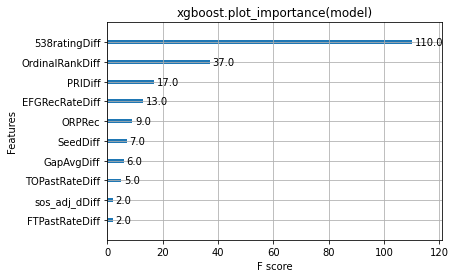

In [111]:
xgboost.plot_importance(model)
plt.title("xgboost.plot_importance(model)")
plt.show()

In [112]:
import shap
shap.initjs()

In [113]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_train[features])

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], df_train[features].iloc[0,:])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [114]:
shap.force_plot(explainer.expected_value, shap_values, df_train[features])

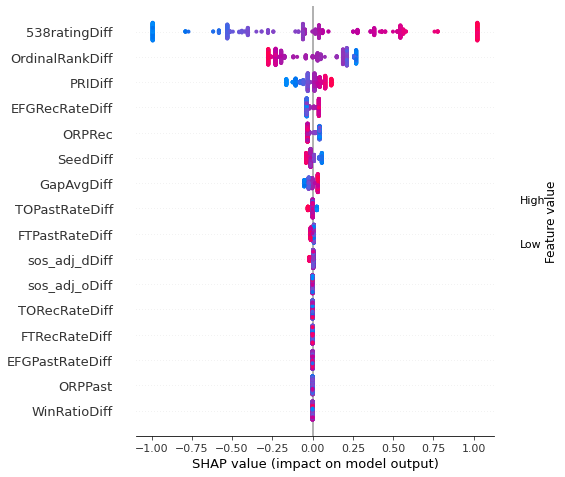

In [115]:
shap.summary_plot(shap_values, df_train[features])

1. 0.589-0.591

In [116]:
def kfold(df, df_test_=None, plot=False, verbose=0, xgb=False, mode="reg", calib=False, tune=False):
    seasons = df['Season'].unique()
    cvs = []
    pred_tests = []
    target = "ScoreDiff" if mode == "reg" else "WinA"
    
    for season in seasons[1:]:
        if verbose:
            print(f'\nValidating on season {season}')
        
        df_train = df[df['Season'] < season].reset_index(drop=True).copy()
        df_val = df[df['Season'] == season].reset_index(drop=True).copy()
        df_test = df_test_.copy()
        
        df_train, df_val, df_test = rescale(features, df_train, df_val, df_test)
        
        if mode == "reg":
            model = ElasticNet(alpha=1, l1_ratio=0.5)
        else:
            if tune:
                model = LogisticRegressionCV(Cs=[10,30,50,70,90,100,120,130,150],cv=5,random_state=42)
                model.fit(df_train[features], df_train[target])
            elif xgb:
                model = XGBClassifier(learning_rate =0.015, n_estimators=800, max_depth=1,
 min_child_weight=4, gamma=0.5, subsample=0.8, reg_lambda = 0.002, colsample_bytree=0.6, eval_metric = 'logloss', nthread=2, seed=42)
                
                evaluation = [(df_val[features], df_val[target])]
                
                model.fit(df_train[features], df_train[target], eval_set=evaluation, early_stopping_rounds=25, verbose=0)
                
            else:
                model = LogisticRegression(C=100)
                model.fit(df_train[features], df_train[target])
        
        if mode == "reg":
            pred = model.predict(df_val[features])
            pred = (pred - pred.min()) / (pred.max() - pred.min())
        else:
            if calib == True: 
                pred = calib_model.predict_proba(df_val[features])[:, 1]
            else:
                pred = model.predict_proba(df_val[features])[:, 1]
#                 iso_reg = IsotonicRegression(y_min = 0, y_max = 1, out_of_bounds = 'clip').fit(pred, df_val[target])
#                 prob_calibrated = iso_reg.predict(model.predict_proba(df_val[features])[:, 1])
        
        if df_test is not None:
            if mode == "reg":
                pred_test = model.predict(df_test[features])
                pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())
            else:
                if calib == True: 
                    pred_test = calib_model.predict_proba(df_test[features])[:, 1]
                else:
                    pred_test = model.predict_proba(df_test[features])[:, 1]
            
            for p in range(len(pred_test)):
                if pred_test[p] <= 0.09:
                    pred_test[p] = 0
                elif pred_test[p] >= 0.91:
                    pred_test[p] = 1
                    
            pred_tests.append(pred_test)
            
            
        if plot:
            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.scatter(pred, df_val['ScoreDiff'].values, s=5)
            plt.grid(True)
            plt.subplot(1, 2, 2)
            sns.histplot(pred)
            plt.show()
        
#         calibrate(df_val['WinA'].values, pred)
        
#         for p in range(len(pred)):
#             if pred[p] <= 0.1:
#                 pred[p] = 0
#             elif pred[p] >= 0.9:
#                 pred[p] = 1
        
        loss = brier_score_loss(df_val['WinA'].values, pred)
        cvs.append(loss)
        

        if verbose:
            print(f'\t -> Scored {loss:.3f}')
        
        del df_train, df_val, df_test
        gc.collect()
        
    print(f'\n Local CV is {np.mean(cvs):.3f}')
    
    return pred_tests

In [117]:
df_test = df_test.fillna(0)


Validating on season 2017


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


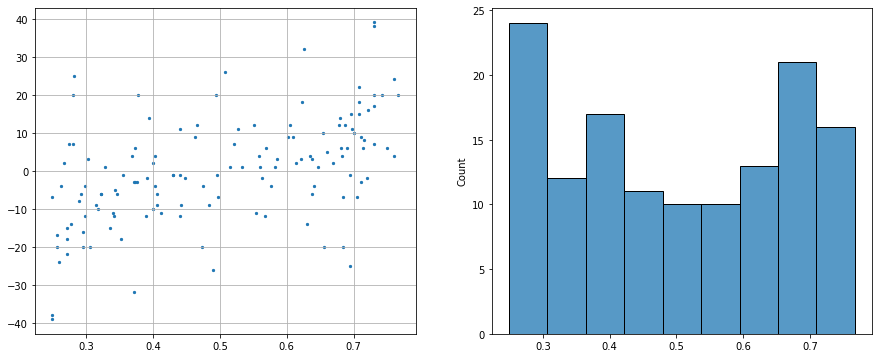

	 -> Scored 0.196

Validating on season 2018


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


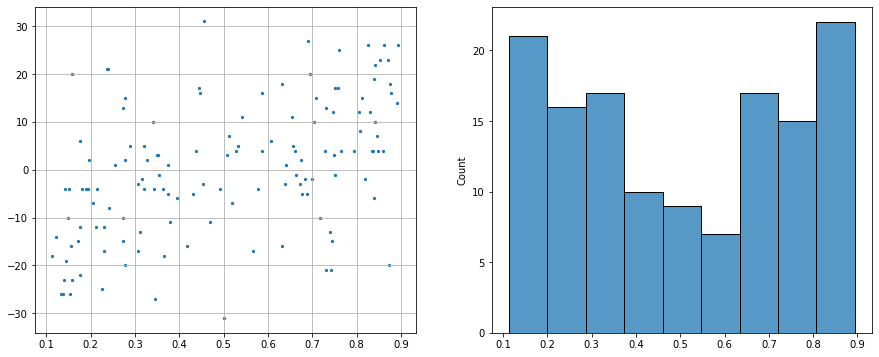

	 -> Scored 0.203

Validating on season 2019


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


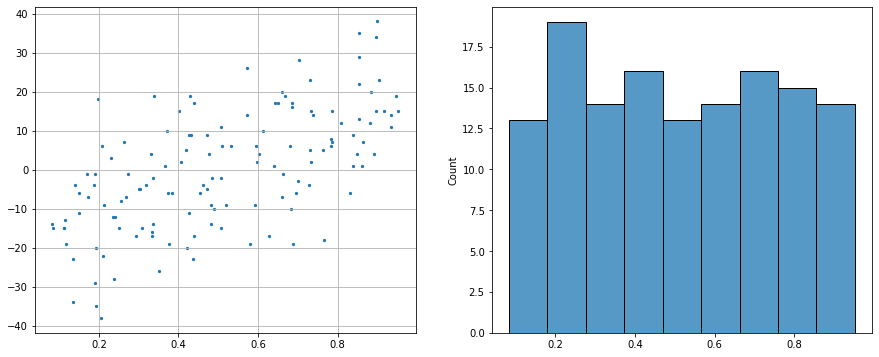

	 -> Scored 0.163

Validating on season 2021


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


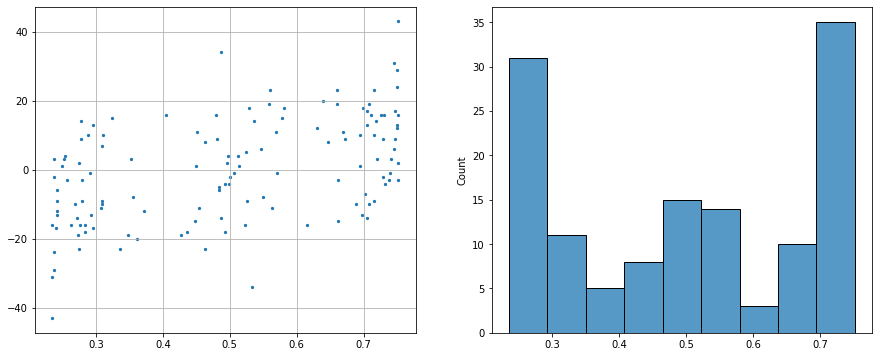

	 -> Scored 0.216

Validating on season 2022


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


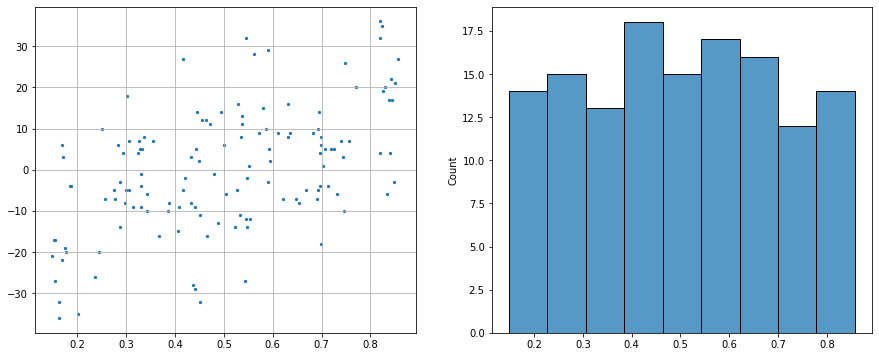

	 -> Scored 0.212

 Local CV is 0.198


In [118]:
pred_tests = kfold(df, df_test, plot=True, xgb = True, verbose=1, tune=False, mode="cls")

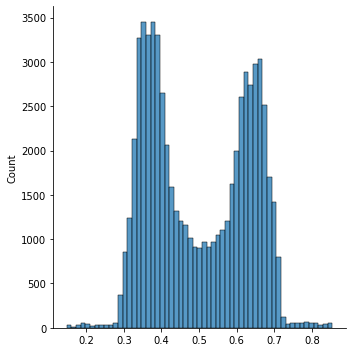

In [119]:
pred_test = np.mean(pred_tests, 0)

_ = sns.displot(pred_test)

# Overriding predictions
- Without overridees, the 4 features model achieved 22nd, which is good but enough !

## Prepare

In [120]:
pred_test.shape

(65703,)

In [121]:
sub = df_test[['ID','Season', 'Pred', 'TeamIdA', 'TeamIdB', 'SeedA', 'SeedB','538ratingDiff', 'PRIDiff', 'sos_adj_dDiff', 'sos_adj_oDiff', 'TORecRateDiff', 'TOPastRateDiff', 'OrdinalRankDiff']].copy()
sub['Pred'] = pred_test

In [122]:
df_teams = pd.read_csv(DATA_PATH + "MTeams.csv")
df_teams = df_teams.drop(['FirstD1Season','LastD1Season'], axis=1)
sub = sub.merge(df_teams, left_on="TeamIdA", right_on="TeamID").drop('TeamID', axis=1).rename(columns={"TeamName": "TeamA"})
sub = sub.merge(df_teams, left_on="TeamIdB", right_on="TeamID").drop('TeamID', axis=1).rename(columns={"TeamName": "TeamB"})

In [123]:
df_seeds['Seed'] = df_seeds['Seed'].apply(lambda x:x[0])

sub = sub.merge(df_seeds, left_on=["TeamIdA", "Season"], right_on=["TeamID", "Season"]).drop('TeamID', axis=1).rename(columns={"Seed": "RegionA"})
sub = sub.merge(df_seeds, left_on=["TeamIdB", "Season"], right_on=["TeamID", "Season"]).drop('TeamID', axis=1).rename(columns={"Seed": "RegionB"})

In [124]:
# best_teams = ['Stanford', 'South Carolina', 'Connecticut', 'Baylor', 'Maryland']  # considered for buff

# strong_teams_safe = best_teams + ['NC State', 'Louisville']  # win 1st round
# strong_teams_risky = strong_teams_safe + ['Texas A&M', 'Arizona', 'Georgia', 'UCLA']  # win 1st round

In [125]:
def overwrite_pred_risky(sub, eps=1e-5):

    new_sub = []
    
    for i, row in sub.iterrows():
        
        # Buff Stanford
        if row['TeamA'] == 'Stanford' and row['SeedB'] >= 3:
            row['Pred'] = 1 - eps
        elif row['TeamB'] == 'Stanford' and row['SeedA'] >= 3:
            row['Pred'] = eps
    
        # Buff South Carolina
        if row['TeamA'] == 'South Carolina' and row['SeedB'] >= 4:
            row['Pred'] = 1 - eps
        elif row['TeamB'] == 'South Carolina' and row['SeedA'] >= 4:
            row['Pred'] = eps
            
        # Buff Connecticut
        if row['TeamA'] == 'Connecticut' and row['SeedB'] >= 4:
            row['Pred'] = 1 - eps
        elif row['TeamB'] == 'Connecticut' and row['SeedA'] >= 4:
            row['Pred'] = eps
            
        # Buff Baylor
        if row['TeamA'] == 'Baylor' and row['SeedB'] >= 3:
            row['Pred'] = 1 - eps
        elif row['TeamB'] == 'Baylor' and row['SeedA'] >= 3:
            row['Pred'] = eps
            
        # Buff Maryland
        if row['TeamA'] == 'Maryland' and row['SeedB'] >= 7:
            row['Pred'] = 1 - eps
        elif row['TeamB'] == 'Maryland' and row['SeedA'] >= 7:
            row['Pred'] = eps
        
        # Strong teams (risky) win their first round
        if row['TeamA'] in strong_teams_risky and row['SeedB'] >= 13:
            row['Pred'] = 1 - eps
        elif row['TeamB'] in strong_teams_risky and row['SeedA'] >= 13:
            row['Pred'] = eps

        new_sub.append(row)
        
    return pd.DataFrame(np.array(new_sub), columns=sub.columns)

## Pattern Rule:
### Set Upset Percentage == Pred


538ratingDiff < -8 & PRIDiff <= -0.06: 

0.102

538ratingDiff < -8 & PRIDiff <= -0.05: 

0.108

538ratingDiff < -5 & PRIDiff <= -0.05: 

0.15

538ratingDiff < -4 & PRIDiff <= -0.05: 

0.165

538ratingDiff < -5 & PRIDiff <= -0.03:

0.19

In [126]:
def overwrite_pred_extrme(sub, eps= 0.0999, err= 0.0199):    
    new_sub = []
    
    for i, row in sub.iterrows():
        err_to = 0
        row['Pred'] = np.clip(row['Pred'], 0.001, 0.999) # clip for safety
        
        if row['Pred'] <= 0.9 and row['Pred'] >= 0.1:
            
            if row['PRIDiff'] >= 0.03 or row['538ratingDiff'] >= 4:
                if row['PRIDiff'] >= 0.06 and row['538ratingDiff'] >= 9:
                    row['Pred'] = 1 - eps
                elif row['PRIDiff'] >= 0.05 and row['538ratingDiff'] >= 7:
                    row['Pred'] = row['Pred'] + (err * 4)
                elif row['PRIDiff'] >= 0.05 and row['538ratingDiff'] >= 6: 
                    row['Pred'] = row['Pred'] + (err * 3)
                elif row['PRIDiff'] >= 0.05 and row['538ratingDiff'] >= 5: 
                    row['Pred'] =row['Pred'] + (err * 2)
                elif row['PRIDiff'] >= 0.04 and row['538ratingDiff'] >= 5: 
                    row['Pred'] = row['Pred'] + err 
                elif row['sos_adj_oDiff'] >= 8 and (row['538ratingDiff'] >= 5 or row['PRIDiff'] >= 0.05): 
                    row['Pred'] = row['Pred'] + (err * 2)
                elif row['sos_adj_dDiff'] <= -5 and (row['538ratingDiff'] >= 5 or row['PRIDiff'] >= 0.05): 
                    row['Pred'] = row['Pred'] + (err * 2)
                
            elif row['PRIDiff'] <= -0.03 or row['538ratingDiff'] <= -4:
                if row['PRIDiff'] <= -0.06 and row['538ratingDiff'] <= -9:
                    row['Pred'] = eps
                elif row['PRIDiff'] <= -0.05 and row['538ratingDiff'] <= -7:
                    row['Pred'] = row['Pred'] - (err * 4)
                elif row['PRIDiff'] <= -0.05 and row['538ratingDiff'] <= -6: 
                    row['Pred'] = row['Pred'] - (err * 3)
                elif row['PRIDiff'] <= -0.05 and row['538ratingDiff'] <= -5: 
                    row['Pred'] = row['Pred'] - (err * 2)
                elif row['PRIDiff'] <= -0.034 and row['538ratingDiff'] <= -5: 
                    row['Pred'] = row['Pred'] - err
                elif row['sos_adj_oDiff'] <= -8 and (row['538ratingDiff'] <= -5 or row['PRIDiff'] <= -0.05): 
                    row['Pred'] = row['Pred'] - (err * 2)
                elif row['sos_adj_dDiff'] <= -5 and (row['538ratingDiff'] <= -5 or row['PRIDiff'] <= -0.05): 
                    row['Pred'] = row['Pred'] - (err * 2)

        row['Pred'] = np.clip(row['Pred'], 0.001, 0.999)
        
        new_sub.append(row)
        
    return pd.DataFrame(np.array(new_sub), columns=sub.columns)

## Pick Upset
(seed 6,7,9)
* Boise St - Northwestern
* illinois - arkansas
* Kentucky - Providence
* Missouri - Utah St

(Seed 5)
* Miami - Drake/next round

(Seed 4)
* Indiana - Kent
* Tennessee - Louisiana (?)

(Seed 3)
* Xavier - Kennesaw St

(seed 2)
* UCLA - UNC Asheville
* (Maybe) Texas - Colgate
### choose one seed 1/2, one seed-3. one seed-4 to upset

## Injuries: 

* HOuston Potential
* West Virginia Minor
Virginia 1
Baylor 1
Missouri
Memphis minor


In [127]:
def overwrite_risk1(sub):
    new_sub = []
    
    for i, row in sub.iterrows():
        
        if row['SeedA'] == 1 and row['SeedB'] == 16:
            row['Pred'] = 99.999
        elif row['SeedB'] == 1 and row['SeedA'] == 16:
            row['Pred'] = 0.001
            
        elif row['TeamA'] == 'Boise St' and row['TeamB'] == 'Northwestern':
            row['Pred'] = row['Pred'] + 0.2
        elif row['TeamA'] == 'Arkansas' and row['TeamB'] == 'Illinois':
            row['Pred'] = row['Pred'] - 0.3
#         elif row['TeamA'] == 'Kentucky' and row['TeamB'] == 'Providence':
#             row['Pred'] = row['Pred'] - 0.3
        elif row['TeamA'] == 'Missouri' and row['TeamB'] == 'Utah St':
            row['Pred'] = row['Pred'] - 0.2
#         elif row['TeamA'] == 'Drake' and row['TeamB'] == 'Miami FL':
#             row['Pred'] = row['Pred'] + 0.2
#         Seed 4
#         elif row['TeamA'] == 'Indiana' and row['TeamB'] == 'Kent':
#             row['Pred'] = row['Pred'] - 0.2
        elif row['TeamA'] == 'Tennessee' and row['TeamB'] == 'Louisiana':
            row['Pred'] = row['Pred'] - 0.2
#         Seed 3
        elif row['TeamA'] == 'Kennesaw' and row['TeamB'] == 'Xavier':
            row['Pred'] = row['Pred'] + 0.2
#         Injuries 
        elif (row['TeamA'] == 'Kansa' or row['TeamA'] == 'Arkansas' or  row['TeamA'] == 'UCLA' or row['TeamA'] == 'Kentucky' or row['TeamA'] == 'West Virginia' or row['TeamA'] == 'Xavier' or row['TeamA'] == 'Tennessee') and (row['SeedB'] - row['SeedA'] <= 3) and (row['TeamB'] != 'Kansa' and row['TeamB'] != 'Arkansas' and  row['TeamB'] != 'UCLA' and row['TeamB'] != 'Kentucky'and row['TeamB'] != 'West Virginia' and row['TeamB'] != 'Xavier' and row['TeamB'] != 'Tennessee'):
            row['Pred'] = row['Pred'] - 0.05
        elif (row['TeamB'] == 'Kansa' or row['TeamB'] == 'Arkansas' or  row['TeamB'] == 'UCLA' or row['TeamB'] == 'Kentucky'or row['TeamB'] == 'West Virginia' or row['TeamB'] == 'Xavier' or row['TeamB'] == 'Tennessee') and (row['SeedA'] - row['SeedB'] <= 3) and (row['TeamA'] != 'Kansa' and row['TeamA'] != 'Arkansas' and  row['TeamA'] != 'UCLA' and row['TeamA'] != 'Kentucky'and row['TeamA'] != 'West Virginia' and row['TeamA'] != 'Xavier' and row['TeamA'] != 'Tennessee'):
            row['Pred'] = row['Pred'] + 0.05
            
#         Pick one strong
        elif row['TeamA'] == 'Duke' and row['SeedB'] >= 4:
            row['Pred'] = row['Pred'] + 0.1
        elif row['TeamB'] == 'Duke' and  row['SeedA'] >= 4:
            row['Pred'] = row['Pred'] - 0.1
            
        row['Pred'] = np.clip(row['Pred'], 0.001, 0.999)
        
        new_sub.append(row)
        
    return pd.DataFrame(np.array(new_sub), columns=sub.columns)   
            

In [128]:
def overwrite_risk2(sub):
    new_sub = []
    
    for i, row in sub.iterrows():
        
        if row['SeedA'] == 1 and row['SeedB'] == 16:
            row['Pred'] = 99.999
        elif row['SeedB'] == 1 and row['SeedA'] == 16:
            row['Pred'] = 0.001
            
        elif row['TeamA'] == 'Boise St' and row['TeamB'] == 'Northwestern':
            row['Pred'] = row['Pred'] + 0.2
        elif row['TeamA'] == 'Arkansas' and row['TeamB'] == 'Illinois':
            row['Pred'] = row['Pred'] - 0.3
        elif row['TeamA'] == 'Kentucky' and row['TeamB'] == 'Providence':
            row['Pred'] = row['Pred'] - 0.3
#         elif row['TeamA'] == 'Missouri' and row['TeamB'] == 'Utah St':
#             row['Pred'] = row['Pred'] - 0.2
        elif row['TeamA'] == 'Drake' and row['TeamB'] == 'Miami FL':
            row['Pred'] = row['Pred'] + 0.2
#         Seed 4
        elif row['TeamA'] == 'Indiana' and row['TeamB'] == 'Kent':
            row['Pred'] = row['Pred'] - 0.2
#         elif row['TeamA'] == 'Tennessee' and row['TeamB'] == 'Louisiana':
#             row['Pred'] = row['Pred'] - 0.2
#         Seed 3
#         elif row['TeamA'] == 'Kennesaw' and row['TeamB'] == 'Xavier':
#             row['Pred'] = row['Pred'] + 0.2
#         Injuries 
        elif (row['TeamA'] == 'Kansa' or row['TeamA'] == 'Arkansas' or  row['TeamA'] == 'UCLA' or row['TeamA'] == 'Kentucky' or row['TeamA'] == 'West Virginia' or row['TeamA'] == 'Xavier' or row['TeamA'] == 'Tennessee') and (row['SeedB'] - row['SeedA'] <= 3) and (row['TeamB'] != 'Kansa' and row['TeamB'] != 'Arkansas' and  row['TeamB'] != 'UCLA' and row['TeamB'] != 'Kentucky'and row['TeamB'] != 'West Virginia' and row['TeamB'] != 'Xavier' and row['TeamB'] != 'Tennessee'):
            row['Pred'] = row['Pred'] - 0.05
        elif (row['TeamB'] == 'Kansa' or row['TeamB'] == 'Arkansas' or  row['TeamB'] == 'UCLA' or row['TeamB'] == 'Kentucky'or row['TeamB'] == 'West Virginia' or row['TeamB'] == 'Xavier' or row['TeamB'] == 'Tennessee') and (row['SeedA'] - row['SeedB'] <= 3) and (row['TeamA'] != 'Kansa' and row['TeamA'] != 'Arkansas' and  row['TeamA'] != 'UCLA' and row['TeamA'] != 'Kentucky'and row['TeamA'] != 'West Virginia' and row['TeamA'] != 'Xavier' and row['TeamA'] != 'Tennessee'):
            row['Pred'] = row['Pred'] + 0.05
            
        #         Pick one strong
        elif row['TeamA'] == 'Alabma' and row['SeedB'] > 3:
            row['Pred'] = 0.999
        elif row['TeamB'] == 'Alabma' and row['SeedA'] > 3:
            row['Pred'] = 0.001   
            
        row['Pred'] = np.clip(row['Pred'], 0.001, 0.999)
        
        new_sub.append(row)
        
    return pd.DataFrame(np.array(new_sub), columns=sub.columns)   
            

In [129]:
sub_pp = overwrite_pred_extrme(sub)

In [130]:
sub_pp1 = overwrite_risk1(sub_pp)
sub_pp2 = overwrite_risk2(sub_pp)

## Submission

In [131]:
final_sub1 = sub_pp1[['ID', 'Pred']].copy()
final_sub1.to_csv('submission_male1.csv', index=False)
final_sub2 = sub_pp2[['ID', 'Pred']].copy()
final_sub2.to_csv('submission_male2.csv', index=False)